In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Check GPU
!nvidia-smi


In [2]:
!pip install torch torchvision tqdm matplotlib


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as transforms

import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm


In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


In [5]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5071, 0.4867, 0.4408),
        std=(0.2675, 0.2565, 0.2761)
    )
])


In [6]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5071, 0.4867, 0.4408),
        std=(0.2675, 0.2565, 0.2761)
    )
])


In [7]:
train_dataset = torchvision.datasets.CIFAR100(
    root="./data",
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = torchvision.datasets.CIFAR100(
    root="./data",
    train=False,
    download=True,
    transform=test_transform
)


In [8]:
num_train = len(train_dataset)
indices = list(range(num_train))
random.shuffle(indices)

val_size = 5000
train_indices = indices[val_size:]
val_indices = indices[:val_size]

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(
    torchvision.datasets.CIFAR100(
        root="./data",
        train=True,
        transform=test_transform
    ),
    val_indices
)


In [9]:
batch_size = 128

train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [10]:
print("Train size:", len(train_subset))
print("Val size:", len(val_subset))
print("Test size:", len(test_dataset))


Train size: 45000
Val size: 5000
Test size: 10000


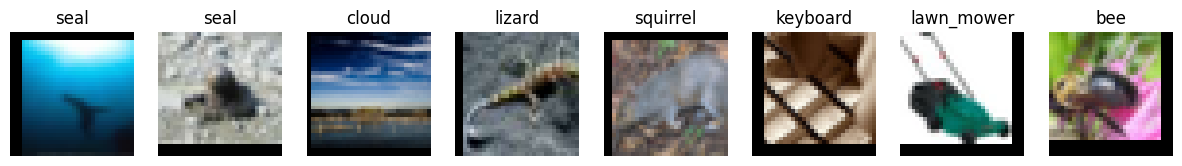

In [11]:
def show_images(images, labels, classes):
    images = images * torch.tensor((0.2675, 0.2565, 0.2761)).view(3,1,1)
    images = images + torch.tensor((0.5071, 0.4867, 0.4408)).view(3,1,1)

    fig, axes = plt.subplots(1, 8, figsize=(15,3))
    for i in range(8):
        axes[i].imshow(images[i].permute(1,2,0))
        axes[i].set_title(classes[labels[i]])
        axes[i].axis("off")
    plt.show()

classes = train_dataset.classes
images, labels = next(iter(train_loader))
show_images(images[:8], labels[:8], classes)


In [12]:
from torchvision.models import resnet18


In [13]:
def get_resnet18_cifar100():
    model = resnet18(weights=None)
    
    # Modify first layer for CIFAR-100 (32x32)
    model.conv1 = nn.Conv2d(
        3, 64, kernel_size=3, stride=1, padding=1, bias=False
    )
    model.maxpool = nn.Identity()  # remove maxpool
    
    # Modify final layer for 100 classes
    model.fc = nn.Linear(model.fc.in_features, 100)
    
    return model


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = get_resnet18_cifar100().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(
    model.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=5e-4
)

scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[60, 120, 160],
    gamma=0.2
)


In [15]:
def accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    
    return 100. * correct / total


In [16]:
def train_model(model, train_loader, val_loader, epochs=200):
    best_val_acc = 0.0
    history = {
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(train_loader, leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()

        train_acc = accuracy(model, train_loader)
        val_acc = accuracy(model, val_loader)

        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Loss: {running_loss:.3f} | "
            f"Train Acc: {train_acc:.2f}% | "
            f"Val Acc: {val_acc:.2f}%"
        )

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "resnet18_cifar100_baseline.pth")

    return history


In [17]:
history = train_model(
    model,
    train_loader,
    val_loader,
    epochs=200
)


Epoch [1/200] | Loss: 1405.202 | Train Acc: 14.05% | Val Acc: 13.58%


Epoch [2/200] | Loss: 1171.967 | Train Acc: 20.15% | Val Acc: 19.46%


Epoch [3/200] | Loss: 1002.010 | Train Acc: 30.79% | Val Acc: 28.60%


Epoch [4/200] | Loss: 846.644 | Train Acc: 34.06% | Val Acc: 31.72%


Epoch [5/200] | Loss: 736.992 | Train Acc: 45.20% | Val Acc: 42.88%


Epoch [6/200] | Loss: 665.269 | Train Acc: 48.61% | Val Acc: 45.94%


Epoch [7/200] | Loss: 614.358 | Train Acc: 49.55% | Val Acc: 45.46%


Epoch [8/200] | Loss: 574.831 | Train Acc: 45.13% | Val Acc: 40.26%


Epoch [9/200] | Loss: 549.400 | Train Acc: 54.38% | Val Acc: 49.04%


Epoch [10/200] | Loss: 525.053 | Train Acc: 50.11% | Val Acc: 45.84%


Epoch [11/200] | Loss: 506.359 | Train Acc: 59.05% | Val Acc: 53.72%


Epoch [12/200] | Loss: 492.536 | Train Acc: 56.79% | Val Acc: 52.22%


Epoch [13/200] | Loss: 476.818 | Train Acc: 56.21% | Val Acc: 49.80%


Epoch [14/200] | Loss: 466.538 | Train Acc: 59.18% | Val Acc: 52.84%


Epoch [15/200] | Loss: 452.976 | Train Acc: 58.04% | Val Acc: 50.68%


Epoch [16/200] | Loss: 446.897 | Train Acc: 57.49% | Val Acc: 50.68%


Epoch [17/200] | Loss: 434.457 | Train Acc: 56.72% | Val Acc: 50.34%


Epoch [18/200] | Loss: 429.453 | Train Acc: 62.05% | Val Acc: 55.26%


Epoch [19/200] | Loss: 423.533 | Train Acc: 62.46% | Val Acc: 54.46%


Epoch [20/200] | Loss: 416.503 | Train Acc: 62.25% | Val Acc: 55.24%


Epoch [21/200] | Loss: 413.457 | Train Acc: 58.98% | Val Acc: 51.16%


Epoch [22/200] | Loss: 406.262 | Train Acc: 62.45% | Val Acc: 54.62%


Epoch [23/200] | Loss: 402.350 | Train Acc: 65.06% | Val Acc: 56.90%


Epoch [24/200] | Loss: 394.814 | Train Acc: 62.84% | Val Acc: 54.90%


Epoch [25/200] | Loss: 394.825 | Train Acc: 64.07% | Val Acc: 55.74%


Epoch [26/200] | Loss: 388.569 | Train Acc: 62.91% | Val Acc: 55.14%


Epoch [27/200] | Loss: 386.432 | Train Acc: 63.60% | Val Acc: 55.16%


Epoch [28/200] | Loss: 385.586 | Train Acc: 64.02% | Val Acc: 55.04%


Epoch [29/200] | Loss: 381.926 | Train Acc: 64.68% | Val Acc: 56.44%


Epoch [30/200] | Loss: 374.051 | Train Acc: 67.54% | Val Acc: 57.46%


Epoch [31/200] | Loss: 374.650 | Train Acc: 64.26% | Val Acc: 54.70%


Epoch [32/200] | Loss: 369.332 | Train Acc: 59.66% | Val Acc: 51.42%


Epoch [33/200] | Loss: 373.537 | Train Acc: 67.08% | Val Acc: 55.84%


Epoch [34/200] | Loss: 367.476 | Train Acc: 60.03% | Val Acc: 50.28%


Epoch [35/200] | Loss: 364.004 | Train Acc: 61.43% | Val Acc: 52.38%


Epoch [36/200] | Loss: 362.736 | Train Acc: 63.22% | Val Acc: 54.46%


Epoch [37/200] | Loss: 358.774 | Train Acc: 62.23% | Val Acc: 53.00%


Epoch [38/200] | Loss: 364.208 | Train Acc: 59.66% | Val Acc: 51.62%


Epoch [39/200] | Loss: 363.228 | Train Acc: 62.60% | Val Acc: 53.24%


Epoch [40/200] | Loss: 355.723 | Train Acc: 60.95% | Val Acc: 49.96%


Epoch [41/200] | Loss: 358.368 | Train Acc: 64.29% | Val Acc: 55.38%


Epoch [42/200] | Loss: 355.164 | Train Acc: 68.84% | Val Acc: 58.54%


Epoch [43/200] | Loss: 353.992 | Train Acc: 65.95% | Val Acc: 56.74%


Epoch [44/200] | Loss: 354.910 | Train Acc: 65.47% | Val Acc: 55.50%


Epoch [45/200] | Loss: 350.924 | Train Acc: 61.69% | Val Acc: 54.12%


Epoch [46/200] | Loss: 350.091 | Train Acc: 62.91% | Val Acc: 54.70%


Epoch [47/200] | Loss: 345.931 | Train Acc: 67.03% | Val Acc: 57.12%


Epoch [48/200] | Loss: 349.609 | Train Acc: 57.98% | Val Acc: 48.66%


Epoch [49/200] | Loss: 348.885 | Train Acc: 67.38% | Val Acc: 57.66%


Epoch [50/200] | Loss: 349.020 | Train Acc: 65.17% | Val Acc: 55.34%


Epoch [51/200] | Loss: 347.738 | Train Acc: 69.16% | Val Acc: 58.96%


Epoch [52/200] | Loss: 344.714 | Train Acc: 62.31% | Val Acc: 53.58%


Epoch [53/200] | Loss: 342.172 | Train Acc: 67.52% | Val Acc: 57.52%


Epoch [54/200] | Loss: 342.975 | Train Acc: 63.03% | Val Acc: 52.50%


Epoch [55/200] | Loss: 342.537 | Train Acc: 68.63% | Val Acc: 58.46%


Epoch [56/200] | Loss: 341.243 | Train Acc: 68.46% | Val Acc: 57.28%


Epoch [57/200] | Loss: 340.098 | Train Acc: 68.90% | Val Acc: 57.60%


Epoch [58/200] | Loss: 342.100 | Train Acc: 67.58% | Val Acc: 57.32%


Epoch [59/200] | Loss: 340.741 | Train Acc: 66.17% | Val Acc: 56.36%


Epoch [60/200] | Loss: 337.641 | Train Acc: 67.16% | Val Acc: 56.02%


Epoch [61/200] | Loss: 180.025 | Train Acc: 90.13% | Val Acc: 73.54%


Epoch [62/200] | Loss: 126.642 | Train Acc: 92.56% | Val Acc: 73.30%


Epoch [63/200] | Loss: 102.035 | Train Acc: 93.96% | Val Acc: 74.06%


Epoch [64/200] | Loss: 85.608 | Train Acc: 95.03% | Val Acc: 73.42%


Epoch [65/200] | Loss: 74.763 | Train Acc: 95.87% | Val Acc: 72.64%


Epoch [66/200] | Loss: 66.454 | Train Acc: 96.20% | Val Acc: 71.70%


Epoch [67/200] | Loss: 59.920 | Train Acc: 96.54% | Val Acc: 72.58%


Epoch [68/200] | Loss: 54.754 | Train Acc: 95.88% | Val Acc: 71.32%


Epoch [69/200] | Loss: 51.611 | Train Acc: 96.76% | Val Acc: 72.14%


Epoch [70/200] | Loss: 49.225 | Train Acc: 97.14% | Val Acc: 72.52%


Epoch [71/200] | Loss: 49.020 | Train Acc: 96.96% | Val Acc: 71.66%


Epoch [72/200] | Loss: 46.831 | Train Acc: 96.78% | Val Acc: 70.06%


Epoch [73/200] | Loss: 50.355 | Train Acc: 95.92% | Val Acc: 70.22%


Epoch [74/200] | Loss: 57.489 | Train Acc: 95.48% | Val Acc: 69.38%


Epoch [75/200] | Loss: 60.093 | Train Acc: 95.64% | Val Acc: 70.18%


Epoch [76/200] | Loss: 59.148 | Train Acc: 95.09% | Val Acc: 69.12%


Epoch [77/200] | Loss: 63.264 | Train Acc: 93.95% | Val Acc: 68.08%


Epoch [78/200] | Loss: 66.201 | Train Acc: 93.80% | Val Acc: 68.40%


Epoch [79/200] | Loss: 68.730 | Train Acc: 94.52% | Val Acc: 69.24%


Epoch [80/200] | Loss: 69.596 | Train Acc: 94.17% | Val Acc: 68.04%


Epoch [81/200] | Loss: 70.705 | Train Acc: 94.62% | Val Acc: 69.36%


Epoch [82/200] | Loss: 71.639 | Train Acc: 93.40% | Val Acc: 68.64%


Epoch [83/200] | Loss: 71.604 | Train Acc: 91.72% | Val Acc: 67.22%


Epoch [84/200] | Loss: 71.247 | Train Acc: 94.00% | Val Acc: 69.06%


Epoch [85/200] | Loss: 72.578 | Train Acc: 92.98% | Val Acc: 66.58%


Epoch [86/200] | Loss: 70.642 | Train Acc: 93.47% | Val Acc: 69.18%


Epoch [87/200] | Loss: 68.149 | Train Acc: 92.41% | Val Acc: 66.50%


Epoch [88/200] | Loss: 68.488 | Train Acc: 92.80% | Val Acc: 67.42%


Epoch [89/200] | Loss: 70.893 | Train Acc: 92.81% | Val Acc: 67.38%


Epoch [90/200] | Loss: 71.001 | Train Acc: 93.60% | Val Acc: 68.08%


Epoch [91/200] | Loss: 71.198 | Train Acc: 92.66% | Val Acc: 66.28%


Epoch [92/200] | Loss: 68.640 | Train Acc: 93.84% | Val Acc: 68.68%


Epoch [93/200] | Loss: 69.372 | Train Acc: 92.74% | Val Acc: 68.46%


Epoch [94/200] | Loss: 64.060 | Train Acc: 92.58% | Val Acc: 67.74%


Epoch [95/200] | Loss: 63.877 | Train Acc: 94.82% | Val Acc: 67.06%


Epoch [96/200] | Loss: 66.695 | Train Acc: 92.89% | Val Acc: 67.38%


Epoch [97/200] | Loss: 66.395 | Train Acc: 94.53% | Val Acc: 68.16%


Epoch [98/200] | Loss: 71.585 | Train Acc: 92.47% | Val Acc: 67.36%


Epoch [99/200] | Loss: 62.256 | Train Acc: 93.49% | Val Acc: 67.04%


Epoch [100/200] | Loss: 62.468 | Train Acc: 94.53% | Val Acc: 68.12%


Epoch [101/200] | Loss: 61.562 | Train Acc: 93.87% | Val Acc: 67.64%


Epoch [102/200] | Loss: 63.282 | Train Acc: 94.75% | Val Acc: 68.18%


Epoch [103/200] | Loss: 60.481 | Train Acc: 93.86% | Val Acc: 68.38%


Epoch [104/200] | Loss: 60.757 | Train Acc: 94.49% | Val Acc: 68.42%


Epoch [105/200] | Loss: 66.296 | Train Acc: 94.64% | Val Acc: 68.66%


Epoch [106/200] | Loss: 62.598 | Train Acc: 92.13% | Val Acc: 66.18%


Epoch [107/200] | Loss: 62.891 | Train Acc: 93.88% | Val Acc: 68.70%


Epoch [108/200] | Loss: 62.318 | Train Acc: 94.22% | Val Acc: 66.74%


Epoch [109/200] | Loss: 60.347 | Train Acc: 93.69% | Val Acc: 68.96%


Epoch [110/200] | Loss: 64.584 | Train Acc: 93.65% | Val Acc: 66.88%


Epoch [111/200] | Loss: 63.045 | Train Acc: 91.05% | Val Acc: 65.00%


Epoch [112/200] | Loss: 63.978 | Train Acc: 94.53% | Val Acc: 67.62%


Epoch [113/200] | Loss: 65.607 | Train Acc: 94.74% | Val Acc: 68.90%


Epoch [114/200] | Loss: 64.144 | Train Acc: 95.09% | Val Acc: 67.88%


Epoch [115/200] | Loss: 57.318 | Train Acc: 92.05% | Val Acc: 66.04%


Epoch [116/200] | Loss: 59.990 | Train Acc: 95.56% | Val Acc: 68.72%


Epoch [117/200] | Loss: 61.510 | Train Acc: 94.55% | Val Acc: 66.86%


Epoch [118/200] | Loss: 57.060 | Train Acc: 92.70% | Val Acc: 66.22%


Epoch [119/200] | Loss: 58.716 | Train Acc: 95.02% | Val Acc: 67.88%


Epoch [120/200] | Loss: 59.456 | Train Acc: 94.74% | Val Acc: 68.36%


Epoch [121/200] | Loss: 23.492 | Train Acc: 99.65% | Val Acc: 74.20%


Epoch [122/200] | Loss: 11.193 | Train Acc: 99.85% | Val Acc: 74.78%


Epoch [123/200] | Loss: 8.769 | Train Acc: 99.90% | Val Acc: 75.16%


Epoch [124/200] | Loss: 6.759 | Train Acc: 99.92% | Val Acc: 75.14%


Epoch [125/200] | Loss: 6.226 | Train Acc: 99.94% | Val Acc: 75.18%


Epoch [126/200] | Loss: 5.541 | Train Acc: 99.94% | Val Acc: 75.52%


Epoch [127/200] | Loss: 5.260 | Train Acc: 99.94% | Val Acc: 75.72%


Epoch [128/200] | Loss: 5.024 | Train Acc: 99.96% | Val Acc: 75.48%


Epoch [129/200] | Loss: 4.510 | Train Acc: 99.97% | Val Acc: 75.64%


Epoch [130/200] | Loss: 4.586 | Train Acc: 99.97% | Val Acc: 75.60%


Epoch [131/200] | Loss: 4.186 | Train Acc: 99.96% | Val Acc: 75.92%


Epoch [132/200] | Loss: 4.145 | Train Acc: 99.96% | Val Acc: 75.98%


Epoch [133/200] | Loss: 4.312 | Train Acc: 99.95% | Val Acc: 75.82%


Epoch [134/200] | Loss: 4.007 | Train Acc: 99.97% | Val Acc: 75.94%


Epoch [135/200] | Loss: 4.151 | Train Acc: 99.97% | Val Acc: 75.98%


Epoch [136/200] | Loss: 3.901 | Train Acc: 99.97% | Val Acc: 75.50%


Epoch [137/200] | Loss: 3.962 | Train Acc: 99.96% | Val Acc: 75.66%


Epoch [138/200] | Loss: 3.865 | Train Acc: 99.96% | Val Acc: 75.50%


Epoch [139/200] | Loss: 3.813 | Train Acc: 99.97% | Val Acc: 75.82%


Epoch [140/200] | Loss: 3.834 | Train Acc: 99.97% | Val Acc: 75.74%


Epoch [141/200] | Loss: 3.709 | Train Acc: 99.97% | Val Acc: 75.92%


Epoch [142/200] | Loss: 3.647 | Train Acc: 99.98% | Val Acc: 76.02%


Epoch [143/200] | Loss: 3.842 | Train Acc: 99.97% | Val Acc: 75.76%


Epoch [144/200] | Loss: 3.627 | Train Acc: 99.97% | Val Acc: 75.80%


Epoch [145/200] | Loss: 3.544 | Train Acc: 99.98% | Val Acc: 76.12%


Epoch [146/200] | Loss: 3.659 | Train Acc: 99.97% | Val Acc: 75.96%


Epoch [147/200] | Loss: 3.629 | Train Acc: 99.97% | Val Acc: 76.46%


Epoch [148/200] | Loss: 3.642 | Train Acc: 99.98% | Val Acc: 76.36%


Epoch [149/200] | Loss: 3.698 | Train Acc: 99.98% | Val Acc: 76.32%


Epoch [150/200] | Loss: 3.695 | Train Acc: 99.98% | Val Acc: 76.38%


Epoch [151/200] | Loss: 3.680 | Train Acc: 99.98% | Val Acc: 76.22%


Epoch [152/200] | Loss: 3.766 | Train Acc: 99.97% | Val Acc: 76.52%


Epoch [153/200] | Loss: 3.684 | Train Acc: 99.98% | Val Acc: 76.54%


Epoch [154/200] | Loss: 3.740 | Train Acc: 99.98% | Val Acc: 76.40%


Epoch [155/200] | Loss: 3.689 | Train Acc: 99.98% | Val Acc: 76.28%


Epoch [156/200] | Loss: 3.713 | Train Acc: 99.99% | Val Acc: 76.00%


Epoch [157/200] | Loss: 3.876 | Train Acc: 99.97% | Val Acc: 76.44%


Epoch [158/200] | Loss: 3.848 | Train Acc: 99.98% | Val Acc: 76.38%


Epoch [159/200] | Loss: 3.772 | Train Acc: 99.97% | Val Acc: 76.26%


Epoch [160/200] | Loss: 3.946 | Train Acc: 99.98% | Val Acc: 76.46%


Epoch [161/200] | Loss: 3.688 | Train Acc: 99.98% | Val Acc: 76.48%


Epoch [162/200] | Loss: 3.689 | Train Acc: 99.98% | Val Acc: 76.30%


Epoch [163/200] | Loss: 3.528 | Train Acc: 99.98% | Val Acc: 76.50%


Epoch [164/200] | Loss: 3.529 | Train Acc: 99.98% | Val Acc: 76.54%


Epoch [165/200] | Loss: 3.583 | Train Acc: 99.98% | Val Acc: 76.72%


Epoch [166/200] | Loss: 3.563 | Train Acc: 99.98% | Val Acc: 76.64%


Epoch [167/200] | Loss: 3.505 | Train Acc: 99.98% | Val Acc: 76.36%


Epoch [168/200] | Loss: 3.596 | Train Acc: 99.98% | Val Acc: 76.50%


Epoch [169/200] | Loss: 3.493 | Train Acc: 99.97% | Val Acc: 76.34%


Epoch [170/200] | Loss: 3.557 | Train Acc: 99.98% | Val Acc: 76.36%


Epoch [171/200] | Loss: 3.582 | Train Acc: 99.98% | Val Acc: 76.38%


Epoch [172/200] | Loss: 3.498 | Train Acc: 99.98% | Val Acc: 76.54%


Epoch [173/200] | Loss: 3.499 | Train Acc: 99.99% | Val Acc: 76.50%


Epoch [174/200] | Loss: 3.485 | Train Acc: 99.98% | Val Acc: 76.34%


Epoch [175/200] | Loss: 3.525 | Train Acc: 99.99% | Val Acc: 76.58%


Epoch [176/200] | Loss: 3.558 | Train Acc: 99.99% | Val Acc: 76.66%


Epoch [177/200] | Loss: 3.524 | Train Acc: 99.98% | Val Acc: 76.54%


Epoch [178/200] | Loss: 3.563 | Train Acc: 99.98% | Val Acc: 76.42%


Epoch [179/200] | Loss: 3.604 | Train Acc: 99.98% | Val Acc: 76.48%


Epoch [180/200] | Loss: 3.580 | Train Acc: 99.98% | Val Acc: 76.48%


Epoch [181/200] | Loss: 3.532 | Train Acc: 99.98% | Val Acc: 76.46%


Epoch [182/200] | Loss: 3.601 | Train Acc: 99.98% | Val Acc: 76.46%


Epoch [183/200] | Loss: 3.431 | Train Acc: 99.98% | Val Acc: 76.46%


Epoch [184/200] | Loss: 3.537 | Train Acc: 99.98% | Val Acc: 76.46%


Epoch [185/200] | Loss: 3.509 | Train Acc: 99.99% | Val Acc: 76.58%


Epoch [186/200] | Loss: 3.500 | Train Acc: 99.98% | Val Acc: 76.44%


Epoch [187/200] | Loss: 3.527 | Train Acc: 99.98% | Val Acc: 76.48%


Epoch [188/200] | Loss: 3.491 | Train Acc: 99.99% | Val Acc: 76.52%


Epoch [189/200] | Loss: 3.511 | Train Acc: 99.98% | Val Acc: 76.44%


Epoch [190/200] | Loss: 3.512 | Train Acc: 99.97% | Val Acc: 76.28%


Epoch [191/200] | Loss: 3.548 | Train Acc: 99.98% | Val Acc: 76.36%


Epoch [192/200] | Loss: 3.646 | Train Acc: 99.98% | Val Acc: 76.36%


Epoch [193/200] | Loss: 3.431 | Train Acc: 99.98% | Val Acc: 76.60%


Epoch [194/200] | Loss: 3.557 | Train Acc: 99.98% | Val Acc: 76.50%


Epoch [195/200] | Loss: 3.478 | Train Acc: 99.98% | Val Acc: 76.64%


Epoch [196/200] | Loss: 3.577 | Train Acc: 99.99% | Val Acc: 76.40%


Epoch [197/200] | Loss: 3.556 | Train Acc: 99.98% | Val Acc: 76.42%


Epoch [198/200] | Loss: 3.652 | Train Acc: 99.98% | Val Acc: 76.58%


Epoch [199/200] | Loss: 3.544 | Train Acc: 99.98% | Val Acc: 76.46%


Epoch [200/200] | Loss: 3.482 | Train Acc: 99.98% | Val Acc: 76.54%


In [20]:
model.load_state_dict(
    torch.load("resnet18_cifar100_baseline.pth")
)

test_acc = accuracy(model, test_loader)
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 76.68%


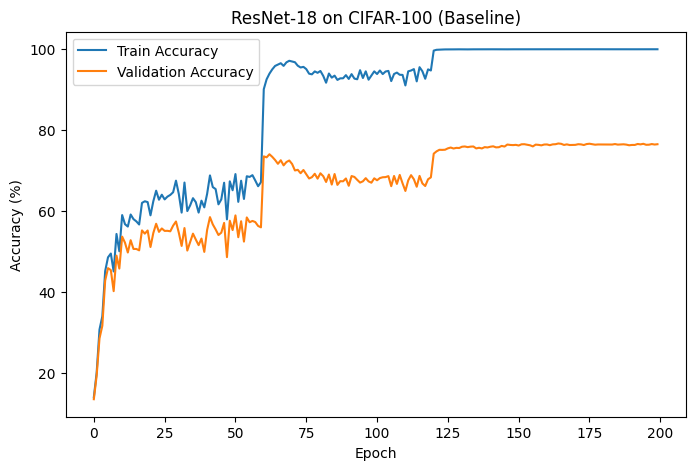

In [21]:
plt.figure(figsize=(8,5))
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("ResNet-18 on CIFAR-100 (Baseline)")
plt.show()


In [22]:
import random
from torch.utils.data import Subset, DataLoader
from collections import Counter
import json


In [23]:
set_seed(42)  # important for reproducibility


In [24]:
def build_sample_forget_split(dataset, forget_size, seed=42):
    random.seed(seed)

    all_indices = list(range(len(dataset)))
    forget_indices = random.sample(all_indices, forget_size)

    retain_indices = [
        idx for idx in all_indices
        if idx not in set(forget_indices)
    ]

    return forget_indices, retain_indices


In [25]:
FORGET_SIZES = [500, 1000, 2500, 5000]

sample_forget_configs = {}


In [26]:
for forget_size in FORGET_SIZES:
    forget_indices, retain_indices = build_sample_forget_split(
        full_train_dataset,
        forget_size=forget_size,
        seed=42
    )

    print(f"\nForget size: {forget_size}")
    print("Forget samples:", len(forget_indices))
    print("Retain samples:", len(retain_indices))

    sample_forget_configs[forget_size] = {
        "forget_indices": forget_indices,
        "retain_indices": retain_indices
    }


NameError: name 'full_train_dataset' is not defined

new

In [27]:
model = get_resnet18_cifar100().to(device)
model.load_state_dict(torch.load("resnet18_cifar100_baseline.pth"))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [28]:
classes = train_dataset.classes

for i, cls in enumerate(classes[:20]):
    print(i, cls)


0 apple
1 aquarium_fish
2 baby
3 bear
4 beaver
5 bed
6 bee
7 beetle
8 bicycle
9 bottle
10 bowl
11 boy
12 bridge
13 bus
14 butterfly
15 camel
16 can
17 castle
18 caterpillar
19 cattle


In [29]:
FORGET_CLASSES = [0]   # e.g., "apple"


In [30]:
FORGET_CLASSES = [0, 12, 45, 78, 93]  # 5 classes


In [31]:
forget_indices = []
retain_indices = []

for idx, (_, label) in enumerate(train_dataset):
    if label in FORGET_CLASSES:
        forget_indices.append(idx)
    else:
        retain_indices.append(idx)

print("Forget samples:", len(forget_indices))
print("Retain samples:", len(retain_indices))


Forget samples: 2500
Retain samples: 47500


In [33]:
forget_dataset = Subset(train_dataset, forget_indices)
retain_dataset = Subset(train_dataset, retain_indices)


In [34]:
forget_loader = DataLoader(
    forget_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

retain_loader = DataLoader(
    retain_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


In [35]:
labels = []
for _, y in forget_loader:
    labels.extend(y.tolist())

print(set(labels))


{0, 12, 45, 78, 93}


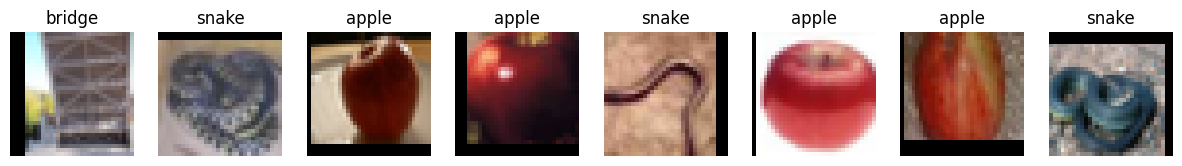

In [36]:
images, labels = next(iter(forget_loader))
show_images(images[:8], labels[:8], classes)


In [37]:
model = get_resnet18_cifar100().to(device)
model.load_state_dict(torch.load("resnet18_cifar100_baseline.pth"))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [38]:
FORGET_SIZES = [100,500, 1000, 2500, 5000]


In [39]:
set_seed(42)


In [40]:
all_indices = list(range(len(train_dataset)))


In [41]:
def create_sample_forget_loaders(
    train_dataset,
    forget_size,
    batch_size=128
):
    indices = list(range(len(train_dataset)))
    random.shuffle(indices)

    forget_indices = indices[:forget_size]
    retain_indices = indices[forget_size:]

    forget_dataset = Subset(train_dataset, forget_indices)
    retain_dataset = Subset(train_dataset, retain_indices)

    forget_loader = DataLoader(
        forget_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    retain_loader = DataLoader(
        retain_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    return forget_loader, retain_loader


In [42]:
forget_loader_500, retain_loader_500 = create_sample_forget_loaders(
    train_dataset, forget_size=500
)

print("Forget samples:", len(forget_loader_500.dataset))
print("Retain samples:", len(retain_loader_500.dataset))


Forget samples: 500
Retain samples: 49500


In [43]:
labels = []
for _, y in forget_loader_500:
    labels.extend(y.tolist())

print("Unique labels in forget set:", len(set(labels)))


Unique labels in forget set: 99


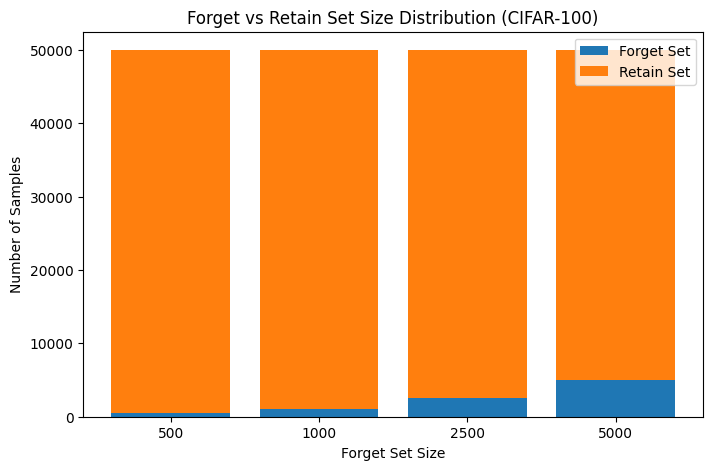

In [44]:
forget_sizes = [500, 1000, 2500, 5000]
retain_sizes = [len(train_dataset) - f for f in forget_sizes]

plt.figure(figsize=(8,5))
plt.bar([str(f) for f in forget_sizes], forget_sizes, label="Forget Set")
plt.bar([str(f) for f in forget_sizes], retain_sizes, bottom=forget_sizes, label="Retain Set")

plt.xlabel("Forget Set Size")
plt.ylabel("Number of Samples")
plt.title("Forget vs Retain Set Size Distribution (CIFAR-100)")
plt.legend()
plt.show()


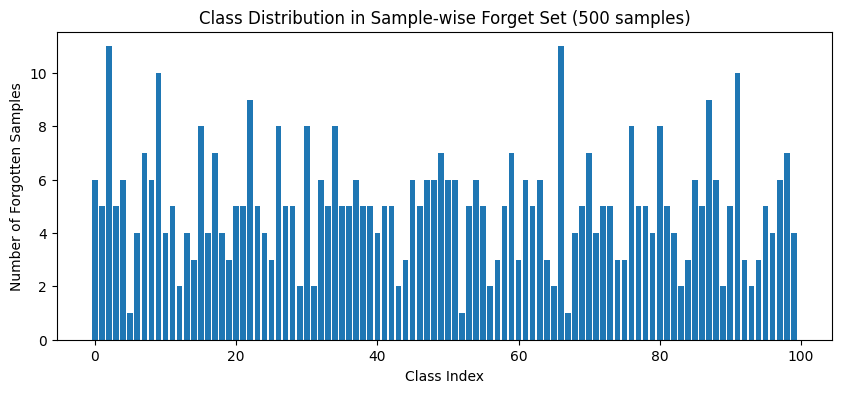

In [45]:
from collections import Counter

forget_loader, _ = create_sample_forget_loaders(train_dataset, 500)

labels = []
for _, y in forget_loader:
    labels.extend(y.tolist())

class_counts = Counter(labels)

plt.figure(figsize=(10,4))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class Index")
plt.ylabel("Number of Forgotten Samples")
plt.title("Class Distribution in Sample-wise Forget Set (500 samples)")
plt.show()


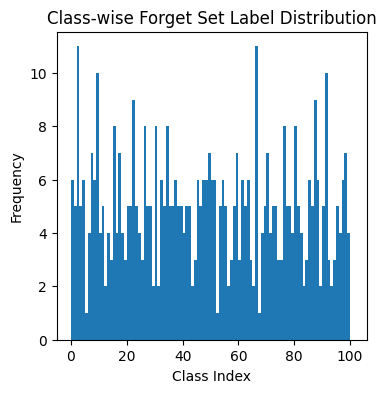

In [46]:
labels = []
for _, y in forget_loader:
    labels.extend(y.tolist())

plt.figure(figsize=(4,4))
plt.hist(labels, bins=range(102))
plt.xlabel("Class Index")
plt.ylabel("Frequency")
plt.title("Class-wise Forget Set Label Distribution")
plt.show()


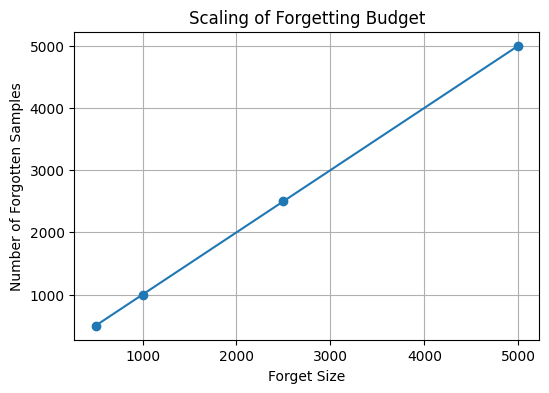

In [47]:
plt.figure(figsize=(6,4))
plt.plot(forget_sizes, forget_sizes, marker="o")
plt.xlabel("Forget Size")
plt.ylabel("Number of Forgotten Samples")
plt.title("Scaling of Forgetting Budget")
plt.grid(True)
plt.show()


In [48]:
overlap = set(forget_indices).intersection(set(retain_indices))
print("Overlap size:", len(overlap))


Overlap size: 0


In [49]:
model = get_resnet18_cifar100().to(device)
model.load_state_dict(torch.load("resnet18_cifar100_baseline.pth"))


<All keys matched successfully>

In [51]:
GA_EPOCHS = 10          # unlearning iterations
GA_LR = 1e-4            # small, controlled ascent
BATCH_SIZE = 128


In [55]:
def evaluate_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, pred = out.max(1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)

    return 100.0 * correct / total


In [56]:
def gradient_ascent_unlearn(
    model,
    forget_loader,
    lr=1e-3,
    ga_steps=1
):
    model.train()

    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=0.9
    )

    criterion = nn.CrossEntropyLoss()

    for _ in range(ga_steps):
        for x, y in forget_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(x)

            # NEGATIVE loss → gradient ASCENT
            loss = -criterion(outputs, y)
            loss.backward()
            optimizer.step()

    return model


In [57]:
FORGET_SIZES = [100, 500, 1000, 2500, 5000]

results = []

for forget_size in FORGET_SIZES:
    print(f"\n--- GA Unlearning | Forget size = {forget_size} ---")

    # Reload baseline (CRITICAL)
    model = get_resnet18_cifar100().to(device)
    model.load_state_dict(torch.load("resnet18_cifar100_baseline.pth"))

    # Create forget/retain loaders
    forget_loader, retain_loader = create_sample_forget_loaders(
        train_dataset,
        forget_size
    )

    # Pre-unlearning accuracy
    forget_acc_before = evaluate_accuracy(model, forget_loader)
    retain_acc_before = evaluate_accuracy(model, retain_loader)

    # Apply GA unlearning
    model = gradient_ascent_unlearn(
        model,
        forget_loader,
        lr=1e-3,
        ga_steps=1
    )

    # Post-unlearning accuracy
    forget_acc_after = evaluate_accuracy(model, forget_loader)
    retain_acc_after = evaluate_accuracy(model, retain_loader)
    test_acc_after = evaluate_accuracy(model, test_loader)

    results.append({
        "forget_size": forget_size,
        "forget_acc_before": forget_acc_before,
        "forget_acc_after": forget_acc_after,
        "retain_acc_after": retain_acc_after,
        "test_acc_after": test_acc_after
    })

    print(f"Forget Acc: {forget_acc_before:.2f} → {forget_acc_after:.2f}")
    print(f"Retain Acc: {retain_acc_after:.2f}")
    print(f"Test Acc: {test_acc_after:.2f}")



--- GA Unlearning | Forget size = 100 ---
Forget Acc: 97.00 → 93.00
Retain Acc: 97.56
Test Acc: 76.63

--- GA Unlearning | Forget size = 500 ---
Forget Acc: 98.60 → 98.60
Retain Acc: 97.56
Test Acc: 76.74

--- GA Unlearning | Forget size = 1000 ---
Forget Acc: 97.10 → 97.20
Retain Acc: 97.58
Test Acc: 76.50

--- GA Unlearning | Forget size = 2500 ---
Forget Acc: 97.28 → 96.96
Retain Acc: 97.57
Test Acc: 76.74

--- GA Unlearning | Forget size = 5000 ---
Forget Acc: 97.58 → 97.24
Retain Acc: 97.58
Test Acc: 76.29


In [58]:
import pandas as pd

df = pd.DataFrame(results)
df.to_csv("ga_unlearning_results.csv", index=False)

df


,forget_size,forget_acc_before,forget_acc_after,retain_acc_after,test_acc_after
0,100,97.00,93.00,97.557114,76.63
1,500,98.60,98.60,97.557576,76.74
2,1000,97.10,97.20,97.583673,76.50
3,2500,97.28,96.96,97.572632,76.74
4,5000,97.58,97.24,97.582222,76.29


In [59]:
df = pd.read_csv("ga_unlearning_results.csv")
df


,forget_size,forget_acc_before,forget_acc_after,retain_acc_after,test_acc_after
0,100,97.00,93.00,97.557114,76.63
1,500,98.60,98.60,97.557576,76.74
2,1000,97.10,97.20,97.583673,76.50
3,2500,97.28,96.96,97.572632,76.74
4,5000,97.58,97.24,97.582222,76.29


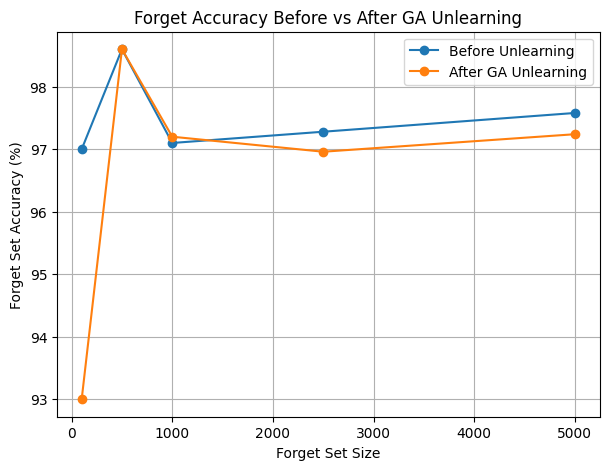

In [60]:
plt.figure(figsize=(7,5))
plt.plot(
    df["forget_size"],
    df["forget_acc_before"],
    marker="o",
    label="Before Unlearning"
)
plt.plot(
    df["forget_size"],
    df["forget_acc_after"],
    marker="o",
    label="After GA Unlearning"
)

plt.xlabel("Forget Set Size")
plt.ylabel("Forget Set Accuracy (%)")
plt.title("Forget Accuracy Before vs After GA Unlearning")
plt.legend()
plt.grid(True)
plt.show()


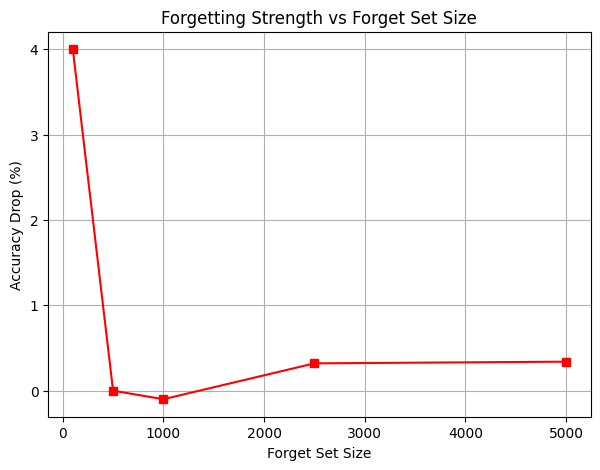

In [61]:
forget_drop = (
    df["forget_acc_before"] - df["forget_acc_after"]
)

plt.figure(figsize=(7,5))
plt.plot(
    df["forget_size"],
    forget_drop,
    marker="s",
    color="red"
)

plt.xlabel("Forget Set Size")
plt.ylabel("Accuracy Drop (%)")
plt.title("Forgetting Strength vs Forget Set Size")
plt.grid(True)
plt.show()


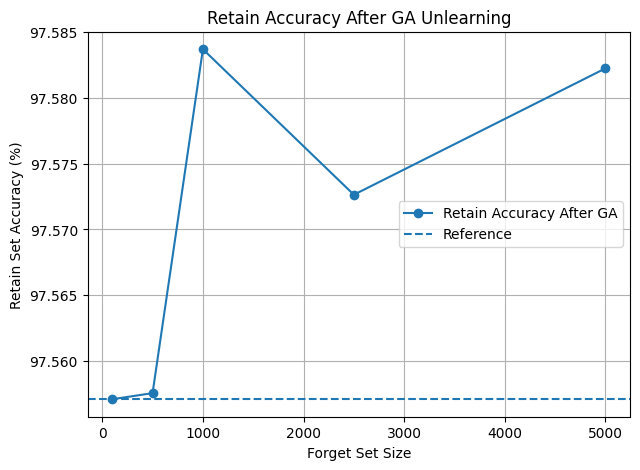

In [62]:
plt.figure(figsize=(7,5))
plt.plot(
    df["forget_size"],
    df["retain_acc_after"],
    marker="o",
    label="Retain Accuracy After GA"
)

plt.axhline(
    y=df["retain_acc_after"].iloc[0],
    linestyle="--",
    label="Reference"
)

plt.xlabel("Forget Set Size")
plt.ylabel("Retain Set Accuracy (%)")
plt.title("Retain Accuracy After GA Unlearning")
plt.legend()
plt.grid(True)
plt.show()


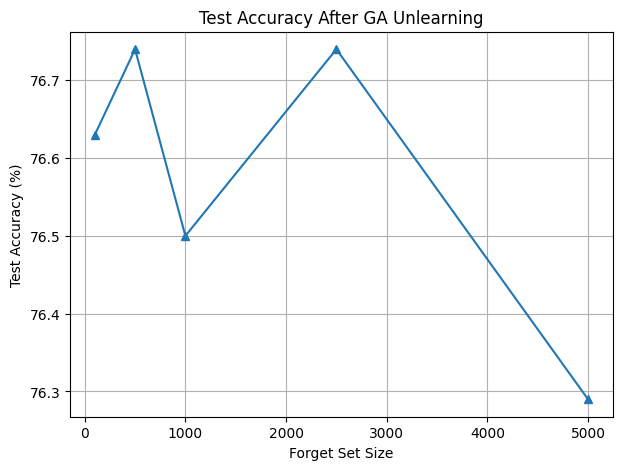

In [63]:
plt.figure(figsize=(7,5))
plt.plot(
    df["forget_size"],
    df["test_acc_after"],
    marker="^"
)

plt.xlabel("Forget Set Size")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy After GA Unlearning")
plt.grid(True)
plt.show()


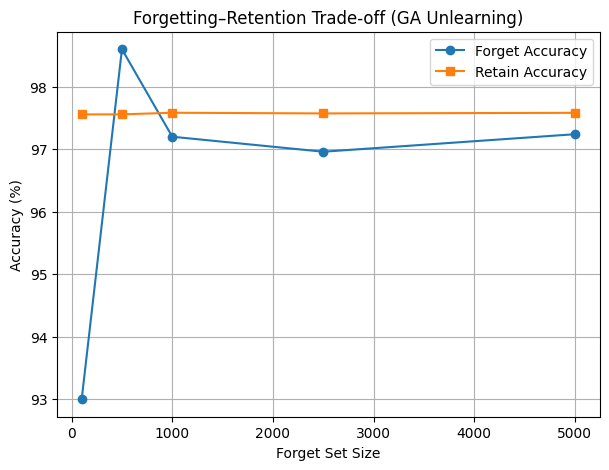

In [64]:
plt.figure(figsize=(7,5))
plt.plot(
    df["forget_size"],
    df["forget_acc_after"],
    marker="o",
    label="Forget Accuracy"
)
plt.plot(
    df["forget_size"],
    df["retain_acc_after"],
    marker="s",
    label="Retain Accuracy"
)

plt.xlabel("Forget Set Size")
plt.ylabel("Accuracy (%)")
plt.title("Forgetting–Retention Trade-off (GA Unlearning)")
plt.legend()
plt.grid(True)
plt.show()


In [65]:
forget_effectiveness = (
    df["forget_acc_before"] - df["forget_acc_after"]
)


In [66]:
df = pd.read_csv("ga_unlearning_results.csv")


In [67]:
df["forget_effectiveness"] = (
    df["forget_acc_before"] - df["forget_acc_after"]
)


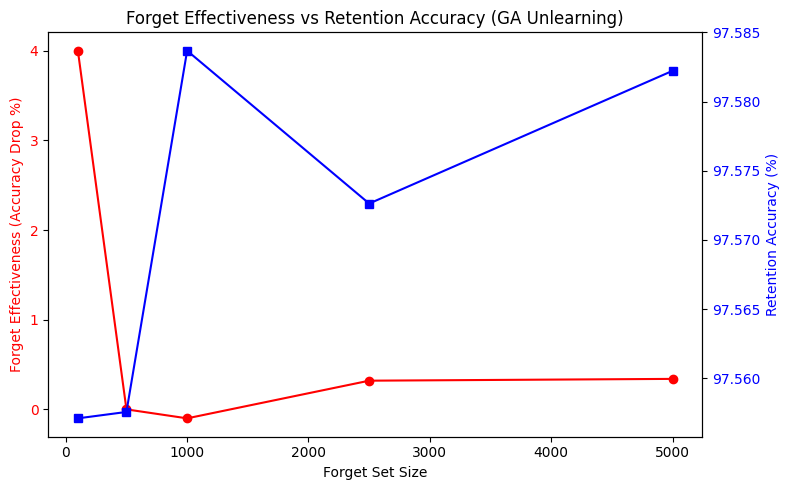

In [68]:
fig, ax1 = plt.subplots(figsize=(8,5))

# Forget effectiveness
ax1.plot(
    df["forget_size"],
    df["forget_effectiveness"],
    marker="o",
    color="red",
    label="Forget Effectiveness"
)
ax1.set_xlabel("Forget Set Size")
ax1.set_ylabel("Forget Effectiveness (Accuracy Drop %)", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Retention accuracy (second axis)
ax2 = ax1.twinx()
ax2.plot(
    df["forget_size"],
    df["retain_acc_after"],
    marker="s",
    color="blue",
    label="Retention Accuracy"
)
ax2.set_ylabel("Retention Accuracy (%)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Title & layout
plt.title("Forget Effectiveness vs Retention Accuracy (GA Unlearning)")
fig.tight_layout()
plt.show()


In [75]:
model = get_resnet18_cifar100().to(device)
model.load_state_dict(torch.load("resnet18_cifar100_baseline.pth"))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [76]:
import pandas as pd
df = pd.read_csv("ga_unlearning_results.csv")
df.head()



,forget_size,forget_acc_before,forget_acc_after,retain_acc_after,test_acc_after
0,100,97.00,93.00,97.557114,76.63
1,500,98.60,98.60,97.557576,76.74
2,1000,97.10,97.20,97.583673,76.50
3,2500,97.28,96.96,97.572632,76.74
4,5000,97.58,97.24,97.582222,76.29


In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np


In [78]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5071, 0.4867, 0.4408),
        (0.2675, 0.2565, 0.2761)
    )
])

train_dataset = torchvision.datasets.CIFAR100(
    root="./data", train=True, download=True, transform=transform
)

test_dataset = torchvision.datasets.CIFAR100(
    root="./data", train=False, download=True, transform=transform
)


In [79]:
from torchvision.models import resnet18

def get_resnet18_cifar100():
    model = resnet18(weights=None)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, 100)
    return model


In [80]:
NUM_SHARDS = 5
random.seed(42)

indices = list(range(len(train_dataset)))
random.shuffle(indices)

shard_size = len(indices) // NUM_SHARDS
shards = []

for i in range(NUM_SHARDS):
    start = i * shard_size
    end = (i + 1) * shard_size if i < NUM_SHARDS - 1 else len(indices)
    shard_indices = indices[start:end]
    shards.append(Subset(train_dataset, shard_indices))

print("Created", len(shards), "shards")


Created 5 shards


In [81]:
def train_shard(shard_dataset, epochs=20):
    loader = DataLoader(
        shard_dataset,
        batch_size=128,
        shuffle=True,
        num_workers=0   # 🔥 SAFE
    )

    model = get_resnet18_cifar100().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs} done")

    return model


In [82]:
shard_models = []

for i, shard in enumerate(shards):
    print(f"\nTraining shard {i+1}/{NUM_SHARDS}")
    model = train_shard(shard, epochs=20)
    shard_models.append(model)

    # Save immediately
    torch.save(model.state_dict(), f"sisa_shard_{i}.pth")



Training shard 1/5
Epoch 1/20 done
Epoch 2/20 done
Epoch 3/20 done
Epoch 4/20 done
Epoch 5/20 done
Epoch 6/20 done
Epoch 7/20 done
Epoch 8/20 done
Epoch 9/20 done
Epoch 10/20 done
Epoch 11/20 done
Epoch 12/20 done
Epoch 13/20 done
Epoch 14/20 done
Epoch 15/20 done
Epoch 16/20 done
Epoch 17/20 done
Epoch 18/20 done
Epoch 19/20 done
Epoch 20/20 done

Training shard 2/5
Epoch 1/20 done
Epoch 2/20 done
Epoch 3/20 done
Epoch 4/20 done
Epoch 5/20 done
Epoch 6/20 done
Epoch 7/20 done
Epoch 8/20 done
Epoch 9/20 done
Epoch 10/20 done
Epoch 11/20 done
Epoch 12/20 done
Epoch 13/20 done
Epoch 14/20 done
Epoch 15/20 done
Epoch 16/20 done
Epoch 17/20 done
Epoch 18/20 done
Epoch 19/20 done
Epoch 20/20 done

Training shard 3/5
Epoch 1/20 done
Epoch 2/20 done
Epoch 3/20 done
Epoch 4/20 done
Epoch 5/20 done
Epoch 6/20 done
Epoch 7/20 done
Epoch 8/20 done
Epoch 9/20 done
Epoch 10/20 done
Epoch 11/20 done
Epoch 12/20 done
Epoch 13/20 done
Epoch 14/20 done
Epoch 15/20 done
Epoch 16/20 done
Epoch 17/20 don

In [83]:
def identify_affected_shards(shards, forget_indices):
    forget_set = set(forget_indices)
    affected = []

    for i, shard in enumerate(shards):
        if set(shard.indices) & forget_set:
            affected.append(i)

    return affected


In [84]:
def sisa_unlearn(shards, shard_models, forget_indices):
    affected = identify_affected_shards(shards, forget_indices)
    print("Affected shards:", affected)

    for i in affected:
        print(f"Retraining shard {i}")
        shard_models[i] = train_shard(shards[i], epochs=10)
        torch.save(shard_models[i].state_dict(), f"sisa_shard_{i}_retrained.pth")

    return shard_models


In [85]:
def sisa_predict(models, x):
    outputs = [m(x) for m in models]
    return torch.mean(torch.stack(outputs), dim=0)


In [86]:
def evaluate_sisa(models, loader):
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = sisa_predict(models, x)
        _, pred = out.max(1)
        correct += pred.eq(y).sum().item()
        total += y.size(0)
    return 100 * correct / total


In [87]:
shard_models = []

for i in range(NUM_SHARDS):
    model = get_resnet18_cifar100().to(device)
    model.load_state_dict(torch.load(f"sisa_shard_{i}.pth"))
    model.eval()
    shard_models.append(model)

print("Loaded all shard models")


Loaded all shard models


In [88]:
def get_forget_indices(train_dataset, forget_size, seed=42):
    random.seed(seed)
    indices = list(range(len(train_dataset)))
    random.shuffle(indices)
    return indices[:forget_size]


In [89]:
def get_loader_from_indices(dataset, indices, batch_size=128):
    subset = Subset(dataset, indices)
    return DataLoader(
        subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0  # SAFE
    )


In [90]:
FORGET_SIZES = [100, 500, 1000, 2500, 5000]

sisa_results = []

for forget_size in FORGET_SIZES:
    print("\n" + "="*50)
    print(f"SISA UNLEARNING | Forget size = {forget_size}")
    print("="*50)

    # Step 1: select forget indices
    forget_indices = get_forget_indices(train_dataset, forget_size)

    retain_indices = list(
        set(range(len(train_dataset))) - set(forget_indices)
    )

    # Step 2: loaders
    forget_loader = get_loader_from_indices(train_dataset, forget_indices)
    retain_loader = get_loader_from_indices(train_dataset, retain_indices)

    # Step 3: evaluate BEFORE unlearning
    forget_acc_before = evaluate_sisa(shard_models, forget_loader)
    retain_acc_before = evaluate_sisa(shard_models, retain_loader)

    # Step 4: SISA unlearning (retrain affected shards)
    shard_models = sisa_unlearn(
        shards,
        shard_models,
        forget_indices
    )

    # Step 5: evaluate AFTER unlearning
    forget_acc_after = evaluate_sisa(shard_models, forget_loader)
    retain_acc_after = evaluate_sisa(shard_models, retain_loader)
    test_acc_after = evaluate_sisa(shard_models, test_loader)

    # Step 6: log
    sisa_results.append({
        "forget_size": forget_size,
        "forget_acc_before": forget_acc_before,
        "forget_acc_after": forget_acc_after,
        "retain_acc_after": retain_acc_after,
        "test_acc_after": test_acc_after
    })

    print(f"Forget Acc: {forget_acc_before:.2f} → {forget_acc_after:.2f}")
    print(f"Retain Acc: {retain_acc_after:.2f}")
    print(f"Test Acc: {test_acc_after:.2f}")

    # Step 7: SAVE after each size (CRITICAL)
    import pandas as pd
    df_sisa = pd.DataFrame(sisa_results)
    df_sisa.to_csv("sisa_unlearning_results.csv", index=False)

    print("Saved sisa_unlearning_results.csv")



SISA UNLEARNING | Forget size = 100
Affected shards: [0]
Retraining shard 0
Epoch 1/10 done
Epoch 2/10 done
Epoch 3/10 done
Epoch 4/10 done
Epoch 5/10 done
Epoch 6/10 done
Epoch 7/10 done
Epoch 8/10 done
Epoch 9/10 done
Epoch 10/10 done
Forget Acc: 42.00 → 41.00
Retain Acc: 48.07
Test Acc: 45.90
Saved sisa_unlearning_results.csv

SISA UNLEARNING | Forget size = 500
Affected shards: [0]
Retraining shard 0
Epoch 1/10 done
Epoch 2/10 done
Epoch 3/10 done
Epoch 4/10 done
Epoch 5/10 done
Epoch 6/10 done
Epoch 7/10 done
Epoch 8/10 done
Epoch 9/10 done
Epoch 10/10 done
Forget Acc: 44.60 → 43.00
Retain Acc: 47.72
Test Acc: 45.64
Saved sisa_unlearning_results.csv

SISA UNLEARNING | Forget size = 1000
Affected shards: [0]
Retraining shard 0
Epoch 1/10 done
Epoch 2/10 done
Epoch 3/10 done
Epoch 4/10 done
Epoch 5/10 done
Epoch 6/10 done
Epoch 7/10 done
Epoch 8/10 done
Epoch 9/10 done
Epoch 10/10 done
Forget Acc: 42.20 → 42.70
Retain Acc: 47.98
Test Acc: 45.62
Saved sisa_unlearning_results.csv

SI

nn

In [91]:
def remove_forget_from_shard(shard, forget_indices):
    shard_set = set(shard.indices)
    forget_set = set(forget_indices)

    new_indices = list(shard_set - forget_set)
    return Subset(shard.dataset, new_indices)


In [92]:
def sisa_unlearn_correct(shards, shard_models, forget_indices):
    affected = identify_affected_shards(shards, forget_indices)
    print("Affected shards:", affected)

    for i in affected:
        print(f"Retraining shard {i} WITHOUT forgotten samples")

        # 🔥 REMOVE forgotten samples
        filtered_shard = remove_forget_from_shard(
            shards[i], forget_indices
        )

        # Retrain from scratch
        shard_models[i] = train_shard(filtered_shard, epochs=20)

        torch.save(
            shard_models[i].state_dict(),
            f"sisa_shard_{i}_retrained.pth"
        )

    return shard_models


In [93]:
NUM_SHARDS = 5
random.seed(42)

indices = list(range(len(train_dataset)))
random.shuffle(indices)

shard_size = len(indices) // NUM_SHARDS
shards = []

for i in range(NUM_SHARDS):
    start = i * shard_size
    end = (i + 1) * shard_size if i < NUM_SHARDS - 1 else len(indices)
    shard_indices = indices[start:end]
    shards.append(Subset(train_dataset, shard_indices))

print("Created", len(shards), "shards")


Created 5 shards


In [94]:
shard_models = []

for i, shard in enumerate(shards):
    print(f"\nTraining initial shard {i+1}/{NUM_SHARDS}")
    model = train_shard(shard, epochs=20)
    shard_models.append(model)

    torch.save(model.state_dict(), f"sisa_shard_{i}.pth")



Training initial shard 1/5
Epoch 1/20 done
Epoch 2/20 done
Epoch 3/20 done
Epoch 4/20 done
Epoch 5/20 done
Epoch 6/20 done
Epoch 7/20 done
Epoch 8/20 done
Epoch 9/20 done
Epoch 10/20 done
Epoch 11/20 done
Epoch 12/20 done
Epoch 13/20 done
Epoch 14/20 done
Epoch 15/20 done
Epoch 16/20 done
Epoch 17/20 done
Epoch 18/20 done
Epoch 19/20 done
Epoch 20/20 done

Training initial shard 2/5
Epoch 1/20 done
Epoch 2/20 done
Epoch 3/20 done
Epoch 4/20 done
Epoch 5/20 done
Epoch 6/20 done
Epoch 7/20 done
Epoch 8/20 done
Epoch 9/20 done
Epoch 10/20 done
Epoch 11/20 done
Epoch 12/20 done
Epoch 13/20 done
Epoch 14/20 done
Epoch 15/20 done
Epoch 16/20 done
Epoch 17/20 done
Epoch 18/20 done
Epoch 19/20 done
Epoch 20/20 done

Training initial shard 3/5
Epoch 1/20 done
Epoch 2/20 done
Epoch 3/20 done
Epoch 4/20 done
Epoch 5/20 done
Epoch 6/20 done
Epoch 7/20 done
Epoch 8/20 done
Epoch 9/20 done
Epoch 10/20 done
Epoch 11/20 done
Epoch 12/20 done
Epoch 13/20 done
Epoch 14/20 done
Epoch 15/20 done
Epoch 16

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

ga_df = pd.read_csv("ga_unlearning_results.csv")
sisa_df = pd.read_csv("sisa_unlearning_results_fixed.csv")

# Compute forget effectiveness
ga_df["forget_effectiveness"] = (
    ga_df["forget_acc_before"] - ga_df["forget_acc_after"]
)
sisa_df["forget_effectiveness"] = (
    sisa_df["forget_acc_before"] - sisa_df["forget_acc_after"]
)


FileNotFoundError: [Errno 2] No such file or directory: 'ga_unlearning_results.csv'

In [97]:
FORGET_SIZES = [100, 500, 1000, 2500, 5000]

sisa_results = []

for forget_size in FORGET_SIZES:
    print("\n" + "="*50)
    print(f"SISA UNLEARNING (CORRECT) | Forget size = {forget_size}")
    print("="*50)

    # 🔁 LOAD FRESH BASELINE SHARD MODELS
    shard_models = []
    for i in range(NUM_SHARDS):
        model = get_resnet18_cifar100().to(device)
        model.load_state_dict(torch.load(f"sisa_shard_{i}.pth"))
        model.eval()
        shard_models.append(model)

    # Select forget indices
    forget_indices = get_forget_indices(train_dataset, forget_size)

    retain_indices = list(
        set(range(len(train_dataset))) - set(forget_indices)
    )

    forget_loader = get_loader_from_indices(train_dataset, forget_indices)
    retain_loader = get_loader_from_indices(train_dataset, retain_indices)

    # BEFORE
    forget_acc_before = evaluate_sisa(shard_models, forget_loader)

    # ✅ TRUE SISA UNLEARNING
    shard_models = sisa_unlearn_correct(
        shards,
        shard_models,
        forget_indices
    )

    # AFTER
    forget_acc_after = evaluate_sisa(shard_models, forget_loader)
    retain_acc_after = evaluate_sisa(shard_models, retain_loader)
    test_acc_after = evaluate_sisa(shard_models, test_loader)

    sisa_results.append({
        "forget_size": forget_size,
        "forget_acc_before": forget_acc_before,
        "forget_acc_after": forget_acc_after,
        "retain_acc_after": retain_acc_after,
        "test_acc_after": test_acc_after
    })

    print(f"Forget Acc: {forget_acc_before:.2f} → {forget_acc_after:.2f}")
    print(f"Retain Acc: {retain_acc_after:.2f}")
    print(f"Test Acc: {test_acc_after:.2f}")

    import pandas as pd
    pd.DataFrame(sisa_results).to_csv(
        "sisa_unlearning_results_fixed.csv",
        index=False
    )

    print("Saved sisa_unlearning_results_fixed.csv")



SISA UNLEARNING (CORRECT) | Forget size = 100
Affected shards: [0]
Retraining shard 0 WITHOUT forgotten samples
Epoch 1/20 done
Epoch 2/20 done
Epoch 3/20 done
Epoch 4/20 done
Epoch 5/20 done
Epoch 6/20 done
Epoch 7/20 done
Epoch 8/20 done
Epoch 9/20 done
Epoch 10/20 done
Epoch 11/20 done
Epoch 12/20 done
Epoch 13/20 done
Epoch 14/20 done
Epoch 15/20 done
Epoch 16/20 done
Epoch 17/20 done
Epoch 18/20 done
Epoch 19/20 done
Epoch 20/20 done
Forget Acc: 41.00 → 37.00
Retain Acc: 50.89
Test Acc: 47.19
Saved sisa_unlearning_results_fixed.csv

SISA UNLEARNING (CORRECT) | Forget size = 500
Affected shards: [0]
Retraining shard 0 WITHOUT forgotten samples
Epoch 1/20 done
Epoch 2/20 done
Epoch 3/20 done
Epoch 4/20 done
Epoch 5/20 done
Epoch 6/20 done
Epoch 7/20 done
Epoch 8/20 done
Epoch 9/20 done
Epoch 10/20 done
Epoch 11/20 done
Epoch 12/20 done
Epoch 13/20 done
Epoch 14/20 done
Epoch 15/20 done
Epoch 16/20 done
Epoch 17/20 done
Epoch 18/20 done
Epoch 19/20 done
Epoch 20/20 done
Forget Acc: 

In [83]:
import pandas as pd

sisa_df_cifar100 = pd.DataFrame({
    "forget_size": [100, 500, 1000, 2500, 5000],
    "forget_acc_before": [41.00, 47.20, 47.10, 48.56, 48.48],
    "forget_acc_after":  [37.00, 45.60, 45.20, 44.28, 43.62],
    "retain_acc_after":  [50.89, 50.63, 50.78, 50.09, 48.57],
    "test_acc_after":    [47.19, 47.28, 47.33, 46.92, 45.72],
})

sisa_df_cifar100["forget_effectiveness"] = (
    sisa_df_cifar100["forget_acc_before"]
    - sisa_df_cifar100["forget_acc_after"]
)

sisa_df_cifar100


,forget_size,forget_acc_before,forget_acc_after,retain_acc_after,test_acc_after,forget_effectiveness
0,100,41.00,37.00,50.89,47.19,4.00
1,500,47.20,45.60,50.63,47.28,1.60
2,1000,47.10,45.20,50.78,47.33,1.90
3,2500,48.56,44.28,50.09,46.92,4.28
4,5000,48.48,43.62,48.57,45.72,4.86


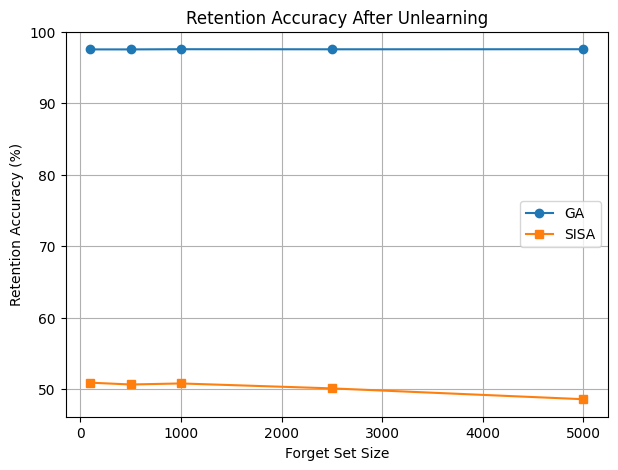

In [100]:
plt.figure(figsize=(7,5))

plt.plot(
    ga_df["forget_size"],
    ga_df["retain_acc_after"],
    marker="o",
    label="GA"
)

plt.plot(
    sisa_df["forget_size"],
    sisa_df["retain_acc_after"],
    marker="s",
    label="SISA"
)

plt.xlabel("Forget Set Size")
plt.ylabel("Retention Accuracy (%)")
plt.title("Retention Accuracy After Unlearning")
plt.legend()
plt.grid(True)
plt.show()


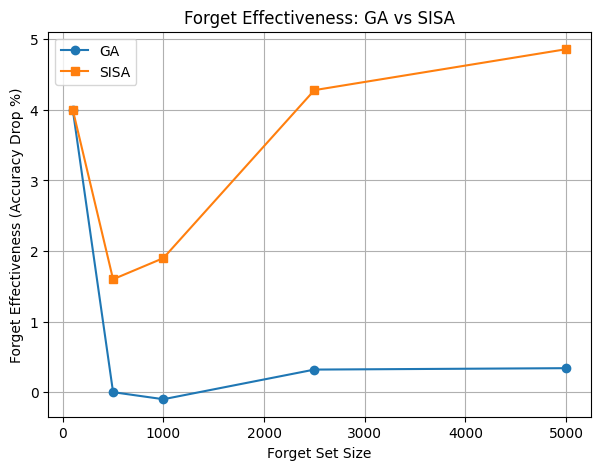

In [99]:
plt.figure(figsize=(7,5))

plt.plot(
    ga_df["forget_size"],
    ga_df["forget_effectiveness"],
    marker="o",
    label="GA"
)

plt.plot(
    sisa_df["forget_size"],
    sisa_df["forget_effectiveness"],
    marker="s",
    label="SISA"
)

plt.xlabel("Forget Set Size")
plt.ylabel("Forget Effectiveness (Accuracy Drop %)")
plt.title("Forget Effectiveness: GA vs SISA")
plt.legend()
plt.grid(True)
plt.show()


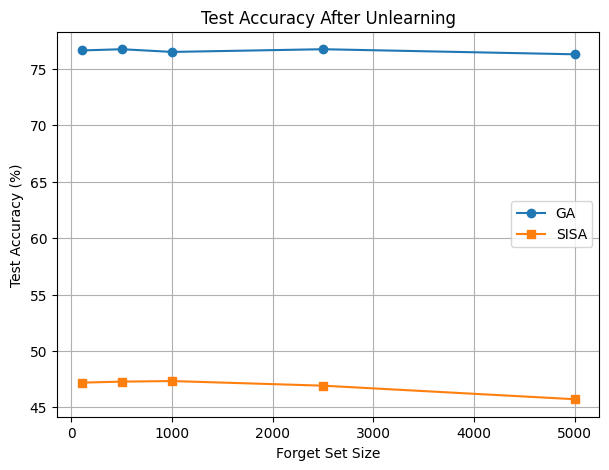

In [101]:
plt.figure(figsize=(7,5))

plt.plot(
    ga_df["forget_size"],
    ga_df["test_acc_after"],
    marker="o",
    label="GA"
)

plt.plot(
    sisa_df["forget_size"],
    sisa_df["test_acc_after"],
    marker="s",
    label="SISA"
)

plt.xlabel("Forget Set Size")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy After Unlearning")
plt.legend()
plt.grid(True)
plt.show()


In [1]:
plt.figure(figsize=(7,5))

plt.scatter(
    ga_df["forget_effectiveness"],
    ga_df["retain_acc_after"],
    label="GA",
    s=80
)

plt.scatter(
    sisa_df["forget_effectiveness"],
    sisa_df["retain_acc_after"],
    label="SISA",
    s=80
)

plt.xlabel("Forget Effectiveness (%)")
plt.ylabel("Retention Accuracy (%)")
plt.title("Forgetting–Retention Trade-off")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'plt' is not defined

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2470, 0.2435, 0.2616)
    )
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2470, 0.2435, 0.2616)
    )
])


In [3]:
train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=test_transform
)

print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))


100%|██████████| 170M/170M [00:03<00:00, 49.0MB/s] 


Train size: 50000
Test size: 10000


In [4]:
indices = list(range(len(train_dataset)))
random.shuffle(indices)

val_size = 5000
val_indices = indices[:val_size]
train_indices = indices[val_size:]

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(
    torchvision.datasets.CIFAR10(
        root="./data",
        train=True,
        transform=test_transform
    ),
    val_indices
)


In [5]:
batch_size = 128

train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [6]:
def get_resnet18_cifar10():
    model = resnet18(weights=None)
    model.conv1 = nn.Conv2d(
        3, 64, kernel_size=3, stride=1, padding=1, bias=False
    )
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
model = get_resnet18_cifar10().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(
    model.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=5e-4
)

scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[60, 120, 160],
    gamma=0.2
)


In [9]:
def accuracy(model, loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, pred = out.max(1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)

    return 100.0 * correct / total


In [10]:
def train_cifar10(model, train_loader, val_loader, epochs=200):
    best_val_acc = 0.0
    history = {"train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()

        train_acc = accuracy(model, train_loader)
        val_acc = accuracy(model, val_loader)

        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Loss: {running_loss:.3f} | "
            f"Train Acc: {train_acc:.2f}% | "
            f"Val Acc: {val_acc:.2f}%"
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(
                model.state_dict(),
                "resnet18_cifar10_baseline.pth"
            )

    return history


In [11]:
history = train_cifar10(
    model,
    train_loader,
    val_loader,
    epochs=200
)


Epoch [1/200] | Loss: 700.936 | Train Acc: 38.02% | Val Acc: 39.60%
Epoch [2/200] | Loss: 517.978 | Train Acc: 45.46% | Val Acc: 48.28%
Epoch [3/200] | Loss: 426.099 | Train Acc: 53.34% | Val Acc: 53.04%
Epoch [4/200] | Loss: 349.927 | Train Acc: 65.64% | Val Acc: 66.40%
Epoch [5/200] | Loss: 291.275 | Train Acc: 66.63% | Val Acc: 66.38%
Epoch [6/200] | Loss: 247.250 | Train Acc: 74.02% | Val Acc: 74.64%
Epoch [7/200] | Loss: 221.219 | Train Acc: 70.62% | Val Acc: 70.38%
Epoch [8/200] | Loss: 202.661 | Train Acc: 78.50% | Val Acc: 79.06%
Epoch [9/200] | Loss: 189.921 | Train Acc: 78.75% | Val Acc: 79.50%
Epoch [10/200] | Loss: 181.506 | Train Acc: 75.17% | Val Acc: 75.68%
Epoch [11/200] | Loss: 175.238 | Train Acc: 78.85% | Val Acc: 79.58%
Epoch [12/200] | Loss: 167.294 | Train Acc: 81.60% | Val Acc: 80.10%
Epoch [13/200] | Loss: 162.573 | Train Acc: 81.00% | Val Acc: 80.22%
Epoch [14/200] | Loss: 158.259 | Train Acc: 80.56% | Val Acc: 80.06%
Epoch [15/200] | Loss: 153.070 | Train Acc:

In [12]:
model.load_state_dict(
    torch.load("resnet18_cifar10_baseline.pth")
)

test_acc = accuracy(model, test_loader)
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 94.81%


In [13]:
model.load_state_dict(
    torch.load("resnet18_cifar10_baseline.pth")
)

test_acc = accuracy(model, test_loader)
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 94.81%


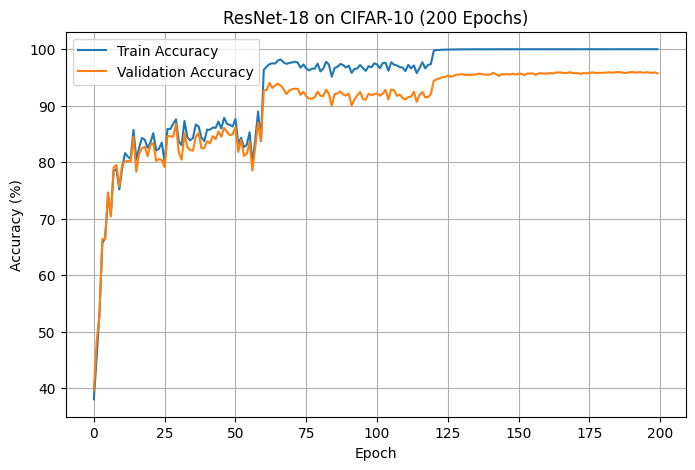

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("ResNet-18 on CIFAR-10 (200 Epochs)")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
FORGET_CLASSES = [0]  # airplane


In [16]:
forget_indices = []
retain_indices = []

for idx, (_, label) in enumerate(train_dataset):
    if label in FORGET_CLASSES:
        forget_indices.append(idx)
    else:
        retain_indices.append(idx)

print("Forget samples:", len(forget_indices))   # ~5000
print("Retain samples:", len(retain_indices))   # ~45000


Forget samples: 5000
Retain samples: 45000


In [17]:
from torch.utils.data import Subset, DataLoader

forget_dataset = Subset(train_dataset, forget_indices)
retain_dataset = Subset(train_dataset, retain_indices)

forget_loader = DataLoader(
    forget_dataset, batch_size=128, shuffle=True, num_workers=2
)

retain_loader = DataLoader(
    retain_dataset, batch_size=128, shuffle=True, num_workers=2
)


In [18]:
labels = []
for _, y in forget_loader:
    labels.extend(y.tolist())

print(set(labels))   # should be {0}


{0}


In [19]:
FORGET_SIZES = [100, 500, 1000, 2500, 5000]


In [20]:
import random

def create_sample_forget_loaders(
    train_dataset, forget_size, seed=42, batch_size=128
):
    random.seed(seed)
    indices = list(range(len(train_dataset)))
    random.shuffle(indices)

    forget_indices = indices[:forget_size]
    retain_indices = indices[forget_size:]

    forget_dataset = Subset(train_dataset, forget_indices)
    retain_dataset = Subset(train_dataset, retain_indices)

    forget_loader = DataLoader(
        forget_dataset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    retain_loader = DataLoader(
        retain_dataset, batch_size=batch_size, shuffle=True, num_workers=2
    )

    return forget_loader, retain_loader


In [21]:
forget_loader_500, _ = create_sample_forget_loaders(train_dataset, 500)

labels = []
for _, y in forget_loader_500:
    labels.extend(y.tolist())

print("Unique labels in forget set:", len(set(labels)))


Unique labels in forget set: 10


In [29]:
model = get_resnet18_cifar10().to(device)
model.load_state_dict(torch.load("resnet18_cifar10_baseline.pth"))
model.eval()



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [30]:
def evaluate_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, pred = out.max(1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)
    return 100.0 * correct / total


In [41]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only classifier
for param in model.fc.parameters():
    param.requires_grad = True


In [46]:
def gradient_ascent_unlearn_head_only(
    model,
    forget_loader,
    lr=1e-2,
    ga_steps=10
):
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    model.train()
    optimizer = torch.optim.SGD(
        model.fc.parameters(),
        lr=lr,
        momentum=0.9
    )
    criterion = nn.CrossEntropyLoss()

    for _ in range(ga_steps):
        for x, y in forget_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = -criterion(model(x), y)
            loss.backward()
            optimizer.step()

    return model


In [47]:
from torchvision import datasets, transforms

plain_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2470, 0.2435, 0.2616)
    )
])

train_dataset_plain = datasets.CIFAR10(
    root="./data",
    train=True,
    download=False,   # already downloaded
    transform=plain_transform
)


In [48]:
model = get_resnet18_cifar10().to(device)
model.load_state_dict(torch.load("resnet18_cifar10_baseline.pth"))

forget_loader, retain_loader = create_sample_forget_loaders(
    train_dataset_plain, 500
)

print("Before GA")
print("Forget Acc:", evaluate_accuracy(model, forget_loader))
print("Retain Acc:", evaluate_accuracy(model, retain_loader))

model = gradient_ascent_unlearn_head_only(
    model,
    forget_loader,
    lr=1e-2,
    ga_steps=10
)

print("\nAfter GA")
print("Forget Acc:", evaluate_accuracy(model, forget_loader))
print("Retain Acc:", evaluate_accuracy(model, retain_loader))
print("Test Acc:", evaluate_accuracy(model, test_loader))


Before GA
Forget Acc: 99.6
Retain Acc: 99.5959595959596

After GA
Forget Acc: 99.0
Retain Acc: 98.39393939393939
Test Acc: 92.92


In [49]:
FORGET_SIZES = [100, 500, 1000, 2500, 5000]

ga_results_cifar10 = []

for forget_size in FORGET_SIZES:
    print("\n" + "="*50)
    print(f"GA UNLEARNING | CIFAR-10 | Forget size = {forget_size}")
    print("="*50)

    # Reload baseline every time (CRITICAL)
    model = get_resnet18_cifar10().to(device)
    model.load_state_dict(torch.load("resnet18_cifar10_baseline.pth"))

    # Create forget / retain loaders
    forget_loader, retain_loader = create_sample_forget_loaders(
    train_dataset_plain, forget_size)


    # Before unlearning
    forget_acc_before = evaluate_accuracy(model, forget_loader)
    retain_acc_before = evaluate_accuracy(model, retain_loader)

    # Apply GA
    model = gradient_ascent_unlearn(
        model,
        forget_loader,
        lr=1e-2,
        ga_steps=10
    )

    # After unlearning
    forget_acc_after = evaluate_accuracy(model, forget_loader)
    retain_acc_after = evaluate_accuracy(model, retain_loader)
    test_acc_after = evaluate_accuracy(model, test_loader)

    ga_results_cifar10.append({
        "forget_size": forget_size,
        "forget_acc_before": forget_acc_before,
        "forget_acc_after": forget_acc_after,
        "retain_acc_after": retain_acc_after,
        "test_acc_after": test_acc_after
    })

    print(f"Forget Acc: {forget_acc_before:.2f} → {forget_acc_after:.2f}")
    print(f"Retain Acc: {retain_acc_after:.2f}")
    print(f"Test Acc: {test_acc_after:.2f}")



GA UNLEARNING | CIFAR-10 | Forget size = 100
Forget Acc: 100.00 → 65.00
Retain Acc: 76.61
Test Acc: 71.99

GA UNLEARNING | CIFAR-10 | Forget size = 500
Forget Acc: 99.60 → 9.40
Retain Acc: 9.30
Test Acc: 8.98

GA UNLEARNING | CIFAR-10 | Forget size = 1000
Forget Acc: 99.80 → 10.60
Retain Acc: 9.99
Test Acc: 10.00

GA UNLEARNING | CIFAR-10 | Forget size = 2500
Forget Acc: 99.72 → 9.40
Retain Acc: 10.03
Test Acc: 10.00

GA UNLEARNING | CIFAR-10 | Forget size = 5000
Forget Acc: 99.56 → 9.90
Retain Acc: 10.01
Test Acc: 10.00


In [50]:
import pandas as pd

ga_df_cifar10 = pd.DataFrame(ga_results_cifar10)
ga_df_cifar10.to_csv("ga_unlearning_results_cifar10.csv", index=False)

ga_df_cifar10


,forget_size,forget_acc_before,forget_acc_after,retain_acc_after,test_acc_after
0,100,100.00,65.0,76.607214,71.99
1,500,99.60,9.4,9.298990,8.98
2,1000,99.80,10.6,9.987755,10.00
3,2500,99.72,9.4,10.031579,10.00
4,5000,99.56,9.9,10.011111,10.00


In [51]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("ga_unlearning_results_cifar10.csv")

# Compute forget effectiveness
df["forget_effectiveness"] = (
    df["forget_acc_before"] - df["forget_acc_after"]
)

df


,forget_size,forget_acc_before,forget_acc_after,retain_acc_after,test_acc_after,forget_effectiveness
0,100,100.00,65.0,76.607214,71.99,35.00
1,500,99.60,9.4,9.298990,8.98,90.20
2,1000,99.80,10.6,9.987755,10.00,89.20
3,2500,99.72,9.4,10.031579,10.00,90.32
4,5000,99.56,9.9,10.011111,10.00,89.66


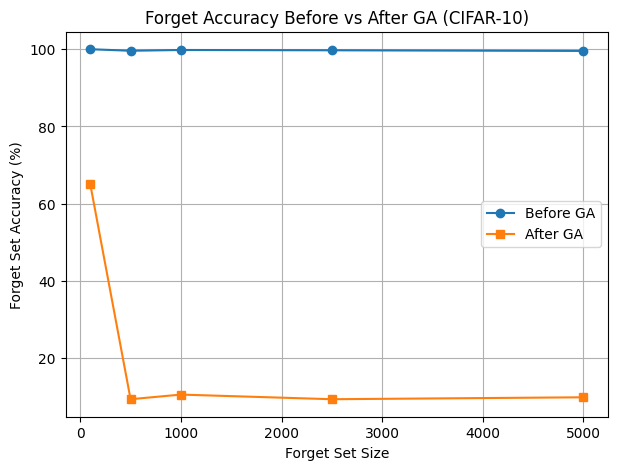

In [52]:
plt.figure(figsize=(7,5))

plt.plot(
    df["forget_size"],
    df["forget_acc_before"],
    marker="o",
    label="Before GA"
)

plt.plot(
    df["forget_size"],
    df["forget_acc_after"],
    marker="s",
    label="After GA"
)

plt.xlabel("Forget Set Size")
plt.ylabel("Forget Set Accuracy (%)")
plt.title("Forget Accuracy Before vs After GA (CIFAR-10)")
plt.legend()
plt.grid(True)
plt.show()


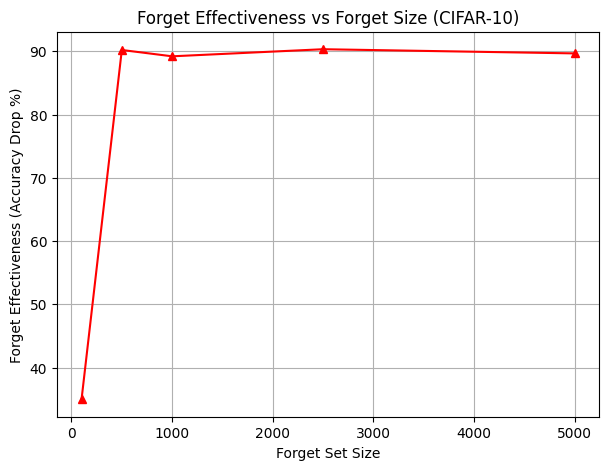

In [53]:
plt.figure(figsize=(7,5))

plt.plot(
    df["forget_size"],
    df["forget_effectiveness"],
    marker="^",
    color="red"
)

plt.xlabel("Forget Set Size")
plt.ylabel("Forget Effectiveness (Accuracy Drop %)")
plt.title("Forget Effectiveness vs Forget Size (CIFAR-10)")
plt.grid(True)
plt.show()


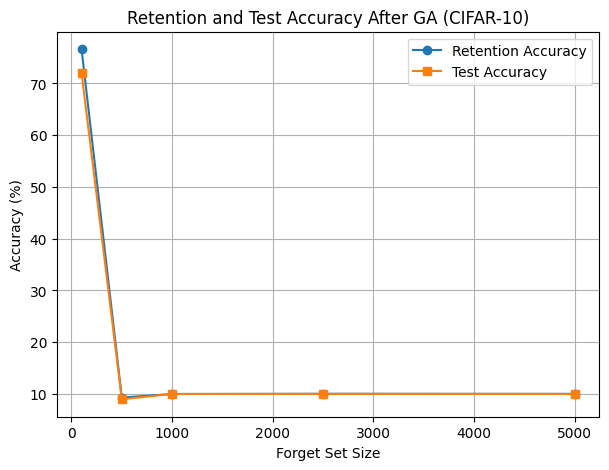

In [54]:
plt.figure(figsize=(7,5))

plt.plot(
    df["forget_size"],
    df["retain_acc_after"],
    marker="o",
    label="Retention Accuracy"
)

plt.plot(
    df["forget_size"],
    df["test_acc_after"],
    marker="s",
    label="Test Accuracy"
)

plt.xlabel("Forget Set Size")
plt.ylabel("Accuracy (%)")
plt.title("Retention and Test Accuracy After GA (CIFAR-10)")
plt.legend()
plt.grid(True)
plt.show()


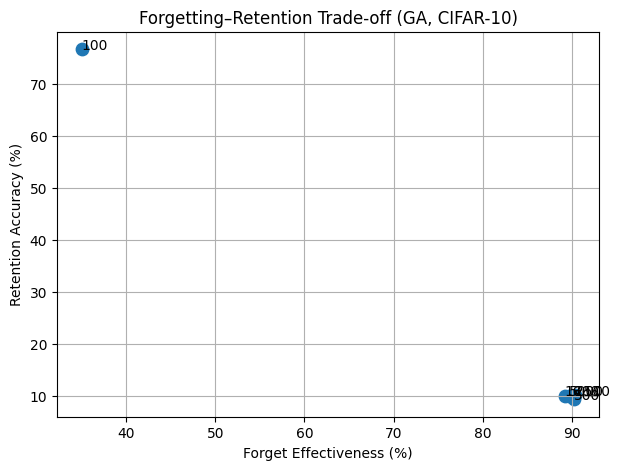

In [55]:
plt.figure(figsize=(7,5))

plt.scatter(
    df["forget_effectiveness"],
    df["retain_acc_after"],
    s=80
)

for i, size in enumerate(df["forget_size"]):
    plt.annotate(
        str(size),
        (df["forget_effectiveness"][i], df["retain_acc_after"][i])
    )

plt.xlabel("Forget Effectiveness (%)")
plt.ylabel("Retention Accuracy (%)")
plt.title("Forgetting–Retention Trade-off (GA, CIFAR-10)")
plt.grid(True)
plt.show()


In [56]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
import torch
import torch.nn as nn
import torch.optim as optim


In [57]:
plain_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2470, 0.2435, 0.2616)
    )
])

train_dataset_plain = datasets.CIFAR10(
    root="./data",
    train=True,
    download=False,
    transform=plain_transform
)

test_dataset_plain = datasets.CIFAR10(
    root="./data",
    train=False,
    download=False,
    transform=plain_transform
)


In [58]:
NUM_SHARDS = 5
random.seed(42)

indices = list(range(len(train_dataset_plain)))
random.shuffle(indices)

shard_size = len(indices) // NUM_SHARDS
shards = []

for i in range(NUM_SHARDS):
    start = i * shard_size
    end = (i + 1) * shard_size if i < NUM_SHARDS - 1 else len(indices)
    shard_indices = indices[start:end]
    shards.append(Subset(train_dataset_plain, shard_indices))

print("Created", len(shards), "shards")


Created 5 shards


In [59]:
def train_shard_model(shard_dataset, epochs=20):
    loader = DataLoader(
        shard_dataset,
        batch_size=128,
        shuffle=True,
        num_workers=0
    )

    model = get_resnet18_cifar10().to(device)
    optimizer = optim.SGD(
        model.parameters(),
        lr=0.1,
        momentum=0.9,
        weight_decay=5e-4
    )
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

        print(f"Shard epoch {epoch+1}/{epochs} done")

    return model


In [60]:
shard_models = []

for i, shard in enumerate(shards):
    print(f"\nTraining shard {i+1}/{NUM_SHARDS}")
    model = train_shard_model(shard, epochs=20)
    shard_models.append(model)
    torch.save(model.state_dict(), f"sisa_cifar10_shard_{i}.pth")



Training shard 1/5
Shard epoch 1/20 done
Shard epoch 2/20 done
Shard epoch 3/20 done
Shard epoch 4/20 done
Shard epoch 5/20 done
Shard epoch 6/20 done
Shard epoch 7/20 done
Shard epoch 8/20 done
Shard epoch 9/20 done
Shard epoch 10/20 done
Shard epoch 11/20 done
Shard epoch 12/20 done
Shard epoch 13/20 done
Shard epoch 14/20 done
Shard epoch 15/20 done
Shard epoch 16/20 done
Shard epoch 17/20 done
Shard epoch 18/20 done
Shard epoch 19/20 done
Shard epoch 20/20 done

Training shard 2/5
Shard epoch 1/20 done
Shard epoch 2/20 done
Shard epoch 3/20 done
Shard epoch 4/20 done
Shard epoch 5/20 done
Shard epoch 6/20 done
Shard epoch 7/20 done
Shard epoch 8/20 done
Shard epoch 9/20 done
Shard epoch 10/20 done
Shard epoch 11/20 done
Shard epoch 12/20 done
Shard epoch 13/20 done
Shard epoch 14/20 done
Shard epoch 15/20 done
Shard epoch 16/20 done
Shard epoch 17/20 done
Shard epoch 18/20 done
Shard epoch 19/20 done
Shard epoch 20/20 done

Training shard 3/5
Shard epoch 1/20 done
Shard epoch 2/20

In [61]:
def identify_affected_shards(shards, forget_indices):
    affected = []
    forget_set = set(forget_indices)
    for i, shard in enumerate(shards):
        if set(shard.indices) & forget_set:
            affected.append(i)
    return affected


In [62]:
def remove_forget_from_shard(shard, forget_indices):
    shard_set = set(shard.indices)
    forget_set = set(forget_indices)
    new_indices = list(shard_set - forget_set)
    return Subset(shard.dataset, new_indices)


In [63]:
def sisa_unlearn_cifar10(
    shards,
    forget_indices,
    epochs=15
):
    new_models = []

    for i in range(NUM_SHARDS):
        model = get_resnet18_cifar10().to(device)
        model.load_state_dict(
            torch.load(f"sisa_cifar10_shard_{i}.pth")
        )
        new_models.append(model)

    affected = identify_affected_shards(shards, forget_indices)
    print("Affected shards:", affected)

    for idx in affected:
        print(f"Retraining shard {idx} WITHOUT forgotten samples")
        filtered_shard = remove_forget_from_shard(
            shards[idx], forget_indices
        )
        new_models[idx] = train_shard_model(
            filtered_shard, epochs=epochs
        )

    return new_models


In [64]:
def sisa_predict(models, x):
    outputs = [m(x) for m in models]
    return torch.mean(torch.stack(outputs), dim=0)


In [65]:
def evaluate_sisa(models, loader):
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = sisa_predict(models, x)
        _, pred = out.max(1)
        correct += pred.eq(y).sum().item()
        total += y.size(0)
    return 100 * correct / total


In [66]:
FORGET_SIZES = [100, 500, 1000, 2500, 5000]
sisa_results_cifar10 = []

test_loader = DataLoader(
    test_dataset_plain,
    batch_size=128,
    shuffle=False,
    num_workers=0
)

for forget_size in FORGET_SIZES:
    print("\n" + "="*50)
    print(f"SISA UNLEARNING | CIFAR-10 | Forget size = {forget_size}")
    print("="*50)

    random.seed(42)
    indices = list(range(len(train_dataset_plain)))
    random.shuffle(indices)
    forget_indices = indices[:forget_size]
    retain_indices = indices[forget_size:]

    forget_loader = DataLoader(
        Subset(train_dataset_plain, forget_indices),
        batch_size=128,
        shuffle=False,
        num_workers=0
    )

    retain_loader = DataLoader(
        Subset(train_dataset_plain, retain_indices),
        batch_size=128,
        shuffle=False,
        num_workers=0
    )

    # BEFORE
    base_models = []
    for i in range(NUM_SHARDS):
        m = get_resnet18_cifar10().to(device)
        m.load_state_dict(torch.load(f"sisa_cifar10_shard_{i}.pth"))
        base_models.append(m)

    forget_acc_before = evaluate_sisa(base_models, forget_loader)

    # UNLEARN
    unlearned_models = sisa_unlearn_cifar10(
        shards, forget_indices
    )

    # AFTER
    forget_acc_after = evaluate_sisa(unlearned_models, forget_loader)
    retain_acc_after = evaluate_sisa(unlearned_models, retain_loader)
    test_acc_after = evaluate_sisa(unlearned_models, test_loader)

    sisa_results_cifar10.append({
        "forget_size": forget_size,
        "forget_acc_before": forget_acc_before,
        "forget_acc_after": forget_acc_after,
        "retain_acc_after": retain_acc_after,
        "test_acc_after": test_acc_after
    })

    print(f"Forget Acc: {forget_acc_before:.2f} → {forget_acc_after:.2f}")
    print(f"Retain Acc: {retain_acc_after:.2f}")
    print(f"Test Acc: {test_acc_after:.2f}")



SISA UNLEARNING | CIFAR-10 | Forget size = 100
Affected shards: [0]
Retraining shard 0 WITHOUT forgotten samples
Shard epoch 1/15 done
Shard epoch 2/15 done
Shard epoch 3/15 done
Shard epoch 4/15 done
Shard epoch 5/15 done
Shard epoch 6/15 done
Shard epoch 7/15 done
Shard epoch 8/15 done
Shard epoch 9/15 done
Shard epoch 10/15 done
Shard epoch 11/15 done
Shard epoch 12/15 done
Shard epoch 13/15 done
Shard epoch 14/15 done
Shard epoch 15/15 done
Forget Acc: 87.00 → 76.00
Retain Acc: 83.21
Test Acc: 73.75

SISA UNLEARNING | CIFAR-10 | Forget size = 500
Affected shards: [0]
Retraining shard 0 WITHOUT forgotten samples
Shard epoch 1/15 done
Shard epoch 2/15 done
Shard epoch 3/15 done
Shard epoch 4/15 done
Shard epoch 5/15 done
Shard epoch 6/15 done
Shard epoch 7/15 done
Shard epoch 8/15 done
Shard epoch 9/15 done
Shard epoch 10/15 done
Shard epoch 11/15 done
Shard epoch 12/15 done
Shard epoch 13/15 done
Shard epoch 14/15 done
Shard epoch 15/15 done
Forget Acc: 84.00 → 75.40
Retain Acc: 83

In [67]:
import pandas as pd

df_sisa_cifar10 = pd.DataFrame(sisa_results_cifar10)
df_sisa_cifar10.to_csv(
    "sisa_unlearning_results_cifar10.csv",
    index=False
)

df_sisa_cifar10


,forget_size,forget_acc_before,forget_acc_after,retain_acc_after,test_acc_after
0,100,87.00,76.00,83.210421,73.75
1,500,84.00,75.40,83.836364,73.59
2,1000,83.50,74.80,83.148980,73.09
3,2500,83.76,74.28,83.147368,72.71
4,5000,83.72,74.58,83.095556,72.72


In [69]:
import pandas as pd
import matplotlib.pyplot as plt

sisa_df = pd.read_csv("sisa_unlearning_results_cifar10.csv")

sisa_df["forget_effectiveness"] = (
    sisa_df["forget_acc_before"] - sisa_df["forget_acc_after"]
)


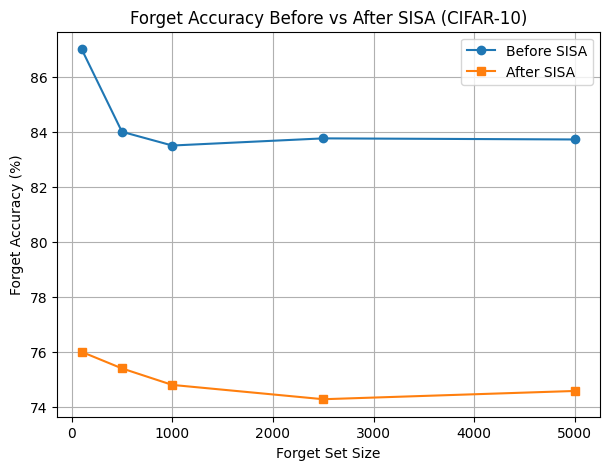

In [70]:
plt.figure(figsize=(7,5))

plt.plot(
    sisa_df["forget_size"],
    sisa_df["forget_acc_before"],
    marker="o",
    label="Before SISA"
)

plt.plot(
    sisa_df["forget_size"],
    sisa_df["forget_acc_after"],
    marker="s",
    label="After SISA"
)

plt.xlabel("Forget Set Size")
plt.ylabel("Forget Accuracy (%)")
plt.title("Forget Accuracy Before vs After SISA (CIFAR-10)")
plt.legend()
plt.grid(True)
plt.show()


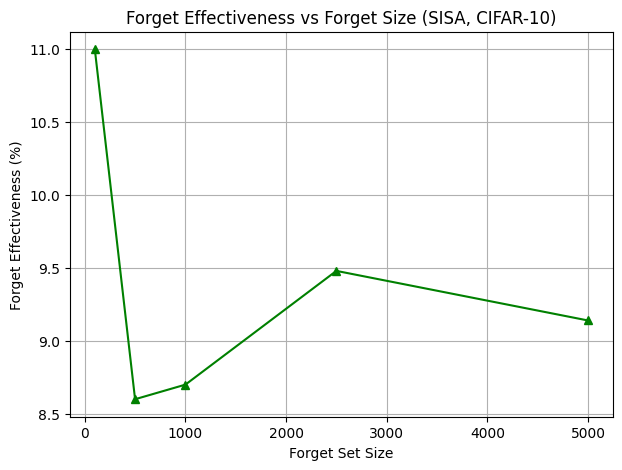

In [71]:
plt.figure(figsize=(7,5))

plt.plot(
    sisa_df["forget_size"],
    sisa_df["forget_effectiveness"],
    marker="^",
    color="green"
)

plt.xlabel("Forget Set Size")
plt.ylabel("Forget Effectiveness (%)")
plt.title("Forget Effectiveness vs Forget Size (SISA, CIFAR-10)")
plt.grid(True)
plt.show()


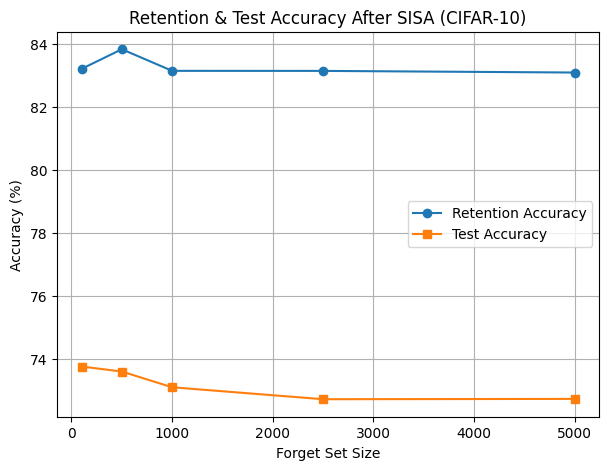

In [72]:
plt.figure(figsize=(7,5))

plt.plot(
    sisa_df["forget_size"],
    sisa_df["retain_acc_after"],
    marker="o",
    label="Retention Accuracy"
)

plt.plot(
    sisa_df["forget_size"],
    sisa_df["test_acc_after"],
    marker="s",
    label="Test Accuracy"
)

plt.xlabel("Forget Set Size")
plt.ylabel("Accuracy (%)")
plt.title("Retention & Test Accuracy After SISA (CIFAR-10)")
plt.legend()
plt.grid(True)
plt.show()


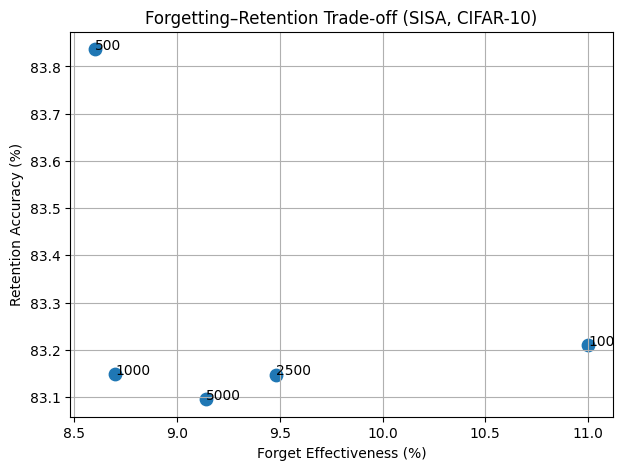

In [73]:
plt.figure(figsize=(7,5))

plt.scatter(
    sisa_df["forget_effectiveness"],
    sisa_df["retain_acc_after"],
    s=80
)

for i, size in enumerate(sisa_df["forget_size"]):
    plt.annotate(
        str(size),
        (sisa_df["forget_effectiveness"][i],
         sisa_df["retain_acc_after"][i])
    )

plt.xlabel("Forget Effectiveness (%)")
plt.ylabel("Retention Accuracy (%)")
plt.title("Forgetting–Retention Trade-off (SISA, CIFAR-10)")
plt.grid(True)
plt.show()


In [74]:
ga_df = pd.read_csv("ga_unlearning_results_cifar10.csv")
ga_df["forget_effectiveness"] = (
    ga_df["forget_acc_before"] - ga_df["forget_acc_after"]
)


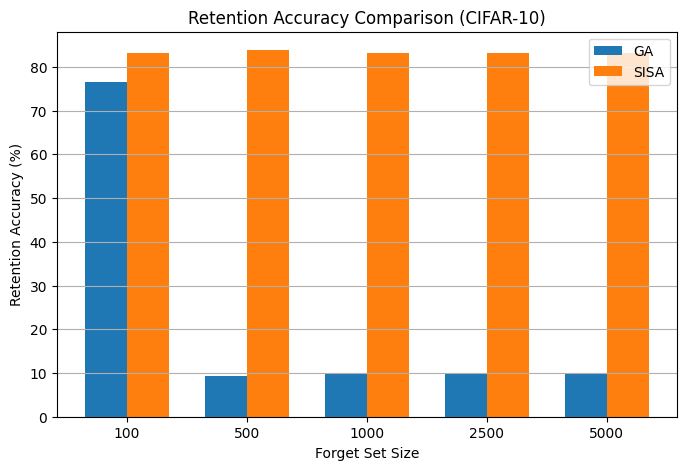

In [77]:
import numpy as np

x = np.arange(len(ga_df))
width = 0.35

plt.figure(figsize=(8,5))

plt.bar(
    x - width/2,
    ga_df["retain_acc_after"],
    width,
    label="GA"
)

plt.bar(
    x + width/2,
    sisa_df["retain_acc_after"],
    width,
    label="SISA"
)

plt.xticks(x, ga_df["forget_size"])
plt.xlabel("Forget Set Size")
plt.ylabel("Retention Accuracy (%)")
plt.title("Retention Accuracy Comparison (CIFAR-10)")
plt.legend()
plt.grid(axis="y")
plt.show()


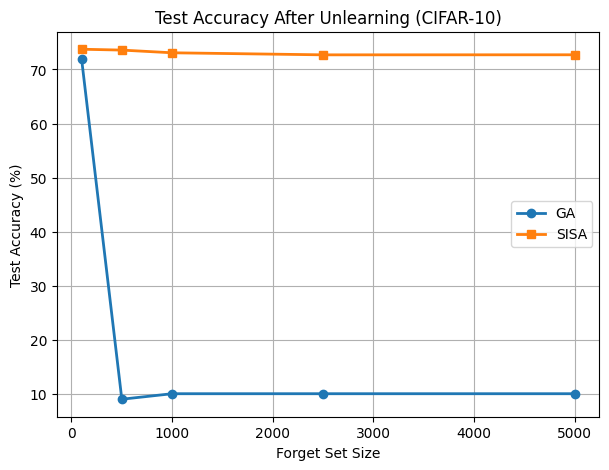

In [78]:
plt.figure(figsize=(7,5))

plt.plot(
    ga_df["forget_size"],
    ga_df["test_acc_after"],
    marker="o",
    linewidth=2,
    label="GA"
)

plt.plot(
    sisa_df["forget_size"],
    sisa_df["test_acc_after"],
    marker="s",
    linewidth=2,
    label="SISA"
)

plt.xlabel("Forget Set Size")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy After Unlearning (CIFAR-10)")
plt.legend()
plt.grid(True)
plt.show()


In [88]:
sisa_df_cifar100.to_csv("sisa_unlearning_results_cifar100.csv", index=False)


In [90]:
import pandas as pd
import matplotlib.pyplot as plt

ga10 = pd.read_csv("ga_unlearning_results_cifar10.csv")
ga100 = pd.read_csv("/kaggle/input/new-one/ga_unlearning_results.csv")

sisa10 = pd.read_csv("sisa_unlearning_results_cifar10.csv")
sisa100 = pd.read_csv("sisa_unlearning_results_cifar100.csv")

for df in [ga10, ga100, sisa10, sisa100]:
    df["forget_effectiveness"] = (
        df["forget_acc_before"] - df["forget_acc_after"]
    )


In [80]:
globals().keys()


dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', 'torch', 'nn', 'optim', 'DataLoader', 'Subset', 'torchvision', 'transforms', 'resnet18', 'random', 'np', 'pd', 'plt', '_i2', 'train_transform', 'test_transform', '_i3', 'train_dataset', 'test_dataset', '_i4', 'indices', 'val_size', 'val_indices', 'train_indices', 'train_subset', 'val_subset', '_i5', 'batch_size', 'train_loader', 'val_loader', 'test_loader', '_i6', 'get_resnet18_cifar10', '_i7', 'device', '_i8', 'model', 'criterion', 'optimizer', 'scheduler', '_i9', 'accuracy', '_i10', 'train_cifar10', '_i11', 'history', '_i12', 'test_acc', '_i13', '_i14', '_i15', 'FORGET_CLASSES', '_i16', 'forget_indices', 'retain_indices', 'idx', 'label', '_i17', 'forget_dataset', 'retain_dataset', 'forget_loader', 'retain_loader', '_i18', 'labels', 'y', '_i19', 'FORGET_SIZES', '_i20', 'c

In [92]:
ga10[["forget_size", "forget_effectiveness"]]


,forget_size,forget_effectiveness
0,100,35.00
1,500,90.20
2,1000,89.20
3,2500,90.32
4,5000,89.66


In [93]:
ga10["forget_effectiveness"].dtype


dtype('float64')

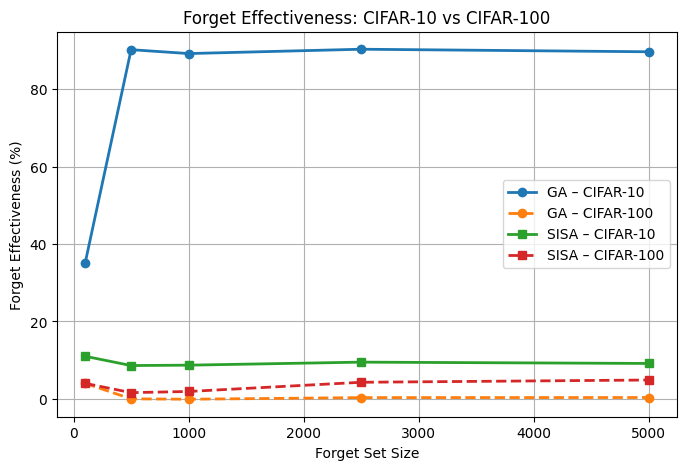

In [94]:
plt.figure(figsize=(8,5))

plt.plot(ga10["forget_size"], ga10["forget_effectiveness"],
         marker="o", linewidth=2, label="GA – CIFAR-10")

plt.plot(ga100["forget_size"], ga100["forget_effectiveness"],
         marker="o", linestyle="--", linewidth=2, label="GA – CIFAR-100")

plt.plot(sisa10["forget_size"], sisa10["forget_effectiveness"],
         marker="s", linewidth=2, label="SISA – CIFAR-10")

plt.plot(sisa100["forget_size"], sisa100["forget_effectiveness"],
         marker="s", linestyle="--", linewidth=2, label="SISA – CIFAR-100")

plt.xlabel("Forget Set Size")
plt.ylabel("Forget Effectiveness (%)")
plt.title("Forget Effectiveness: CIFAR-10 vs CIFAR-100")
plt.legend()
plt.grid(True)
plt.show()


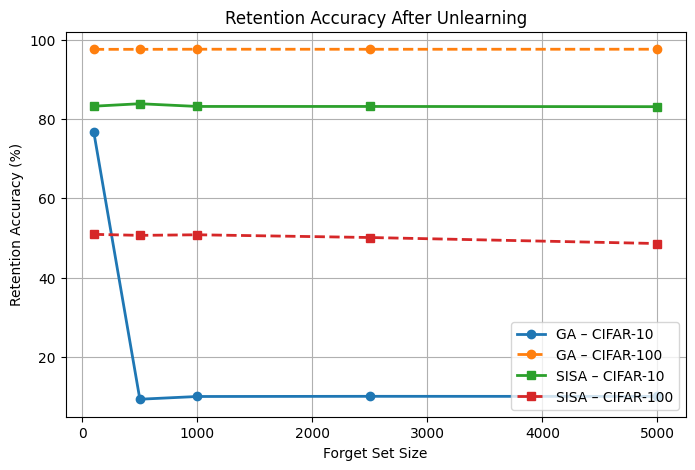

In [95]:
plt.figure(figsize=(8,5))

plt.plot(ga10["forget_size"], ga10["retain_acc_after"],
         marker="o", linewidth=2, label="GA – CIFAR-10")

plt.plot(ga100["forget_size"], ga100["retain_acc_after"],
         marker="o", linestyle="--", linewidth=2, label="GA – CIFAR-100")

plt.plot(sisa10["forget_size"], sisa10["retain_acc_after"],
         marker="s", linewidth=2, label="SISA – CIFAR-10")

plt.plot(sisa100["forget_size"], sisa100["retain_acc_after"],
         marker="s", linestyle="--", linewidth=2, label="SISA – CIFAR-100")

plt.xlabel("Forget Set Size")
plt.ylabel("Retention Accuracy (%)")
plt.title("Retention Accuracy After Unlearning")
plt.legend()
plt.grid(True)
plt.show()


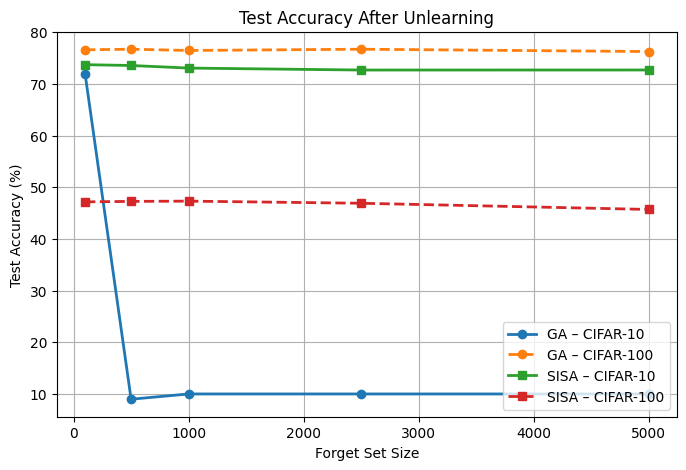

In [96]:
plt.figure(figsize=(8,5))

plt.plot(ga10["forget_size"], ga10["test_acc_after"],
         marker="o", linewidth=2, label="GA – CIFAR-10")

plt.plot(ga100["forget_size"], ga100["test_acc_after"],
         marker="o", linestyle="--", linewidth=2, label="GA – CIFAR-100")

plt.plot(sisa10["forget_size"], sisa10["test_acc_after"],
         marker="s", linewidth=2, label="SISA – CIFAR-10")

plt.plot(sisa100["forget_size"], sisa100["test_acc_after"],
         marker="s", linestyle="--", linewidth=2, label="SISA – CIFAR-100")

plt.xlabel("Forget Set Size")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy After Unlearning")
plt.legend()
plt.grid(True)
plt.show()


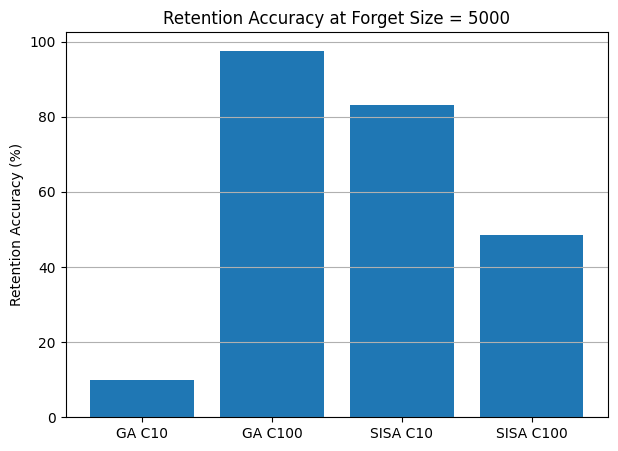

In [97]:
labels = [
    "GA C10", "GA C100",
    "SISA C10", "SISA C100"
]

values = [
    ga10["retain_acc_after"].iloc[-1],
    ga100["retain_acc_after"].iloc[-1],
    sisa10["retain_acc_after"].iloc[-1],
    sisa100["retain_acc_after"].iloc[-1],
]

plt.figure(figsize=(7,5))
plt.bar(labels, values)
plt.ylabel("Retention Accuracy (%)")
plt.title("Retention Accuracy at Forget Size = 5000")
plt.grid(axis="y")
plt.show()


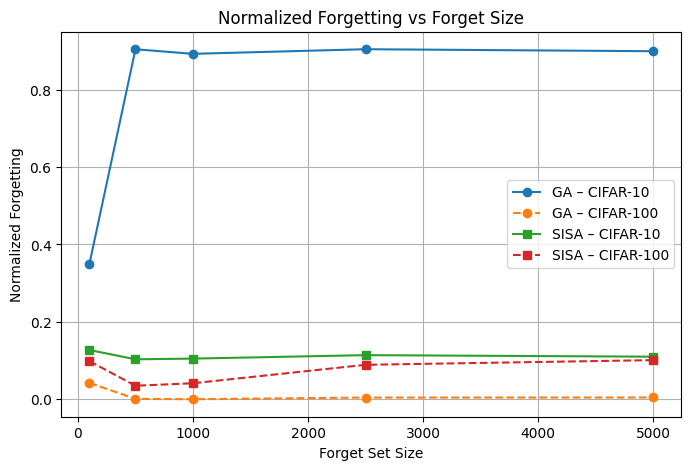

In [99]:
for df in [ga10, ga100, sisa10, sisa100]:
    df["normalized_forget"] = (
        (df["forget_acc_before"] - df["forget_acc_after"])
        / df["forget_acc_before"]
    )

plt.figure(figsize=(8,5))

plt.plot(ga10["forget_size"], ga10["normalized_forget"],
         marker="o", label="GA – CIFAR-10")

plt.plot(ga100["forget_size"], ga100["normalized_forget"],
         marker="o", linestyle="--", label="GA – CIFAR-100")

plt.plot(sisa10["forget_size"], sisa10["normalized_forget"],
         marker="s", label="SISA – CIFAR-10")

plt.plot(sisa100["forget_size"], sisa100["normalized_forget"],
         marker="s", linestyle="--", label="SISA – CIFAR-100")

plt.xlabel("Forget Set Size")
plt.ylabel("Normalized Forgetting")
plt.title("Normalized Forgetting vs Forget Size")
plt.legend()
plt.grid(True)
plt.show()


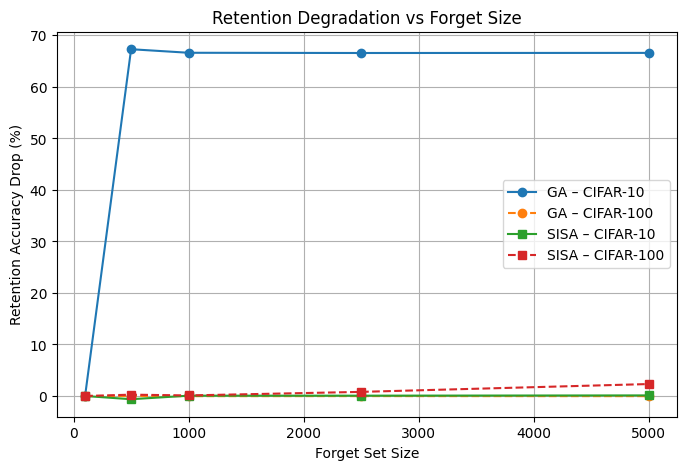

In [100]:
for df in [ga10, ga100, sisa10, sisa100]:
    df["retention_drop"] = (
        df["retain_acc_after"].iloc[0] - df["retain_acc_after"]
    )

plt.figure(figsize=(8,5))

plt.plot(ga10["forget_size"], ga10["retention_drop"],
         marker="o", label="GA – CIFAR-10")

plt.plot(ga100["forget_size"], ga100["retention_drop"],
         marker="o", linestyle="--", label="GA – CIFAR-100")

plt.plot(sisa10["forget_size"], sisa10["retention_drop"],
         marker="s", label="SISA – CIFAR-10")

plt.plot(sisa100["forget_size"], sisa100["retention_drop"],
         marker="s", linestyle="--", label="SISA – CIFAR-100")

plt.xlabel("Forget Set Size")
plt.ylabel("Retention Accuracy Drop (%)")
plt.title("Retention Degradation vs Forget Size")
plt.legend()
plt.grid(True)
plt.show()


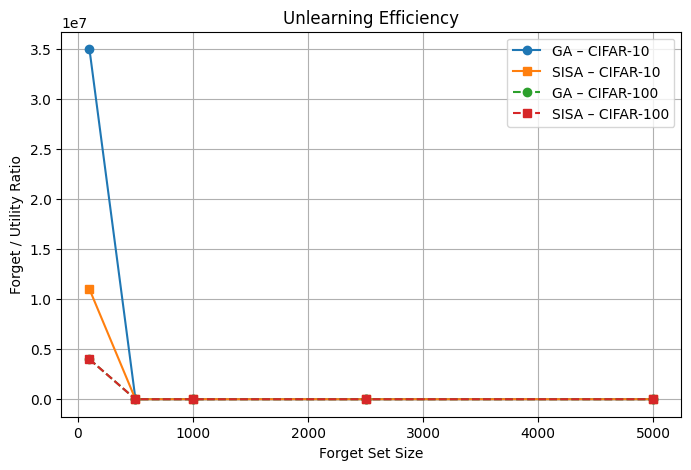

In [101]:
def utility_ratio(df):
    test_drop = df["test_acc_after"].iloc[0] - df["test_acc_after"]
    return df["forget_effectiveness"] / (test_drop + 1e-6)

plt.figure(figsize=(8,5))

plt.plot(ga10["forget_size"], utility_ratio(ga10),
         marker="o", label="GA – CIFAR-10")

plt.plot(sisa10["forget_size"], utility_ratio(sisa10),
         marker="s", label="SISA – CIFAR-10")

plt.plot(ga100["forget_size"], utility_ratio(ga100),
         marker="o", linestyle="--", label="GA – CIFAR-100")

plt.plot(sisa100["forget_size"], utility_ratio(sisa100),
         marker="s", linestyle="--", label="SISA – CIFAR-100")

plt.xlabel("Forget Set Size")
plt.ylabel("Forget / Utility Ratio")
plt.title("Unlearning Efficiency")
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_55/2567517109.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(methods.values(), labels=methods.keys())


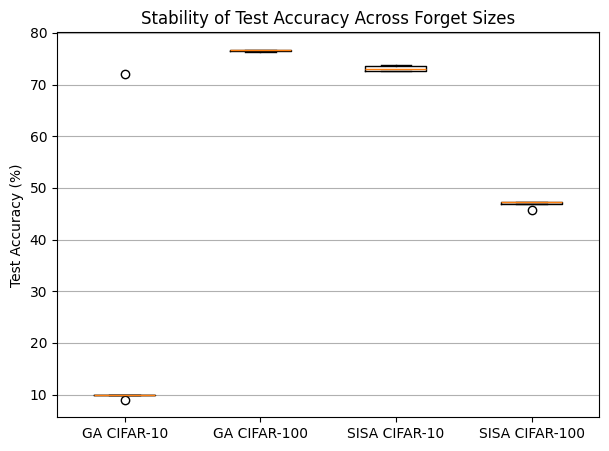

In [102]:
methods = {
    "GA CIFAR-10": ga10["test_acc_after"],
    "GA CIFAR-100": ga100["test_acc_after"],
    "SISA CIFAR-10": sisa10["test_acc_after"],
    "SISA CIFAR-100": sisa100["test_acc_after"],
}

plt.figure(figsize=(7,5))
plt.boxplot(methods.values(), labels=methods.keys())
plt.ylabel("Test Accuracy (%)")
plt.title("Stability of Test Accuracy Across Forget Sizes")
plt.grid(axis="y")
plt.show()


In [104]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

forget_sizes = ga10["forget_size"].values

forget_matrix = np.array([
    ga10["forget_effectiveness"].values,
    ga100["forget_effectiveness"].values,
    sisa10["forget_effectiveness"].values,
    sisa100["forget_effectiveness"].values
])

labels = ["GA-C10", "GA-C100", "SISA-C10", "SISA-C100"]


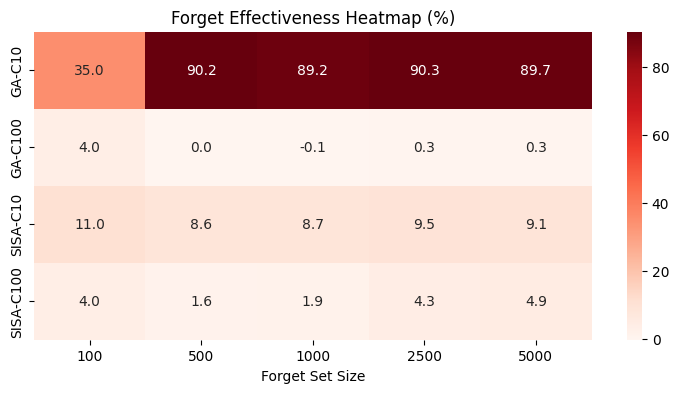

In [106]:
plt.figure(figsize=(9,4))
sns.heatmap(
    forget_matrix,
    annot=True,
    fmt=".1f",
    cmap="Reds",
    xticklabels=forget_sizes,
    yticklabels=labels
)
plt.xlabel("Forget Set Size")
plt.title("Forget Effectiveness Heatmap (%)")
plt.show()


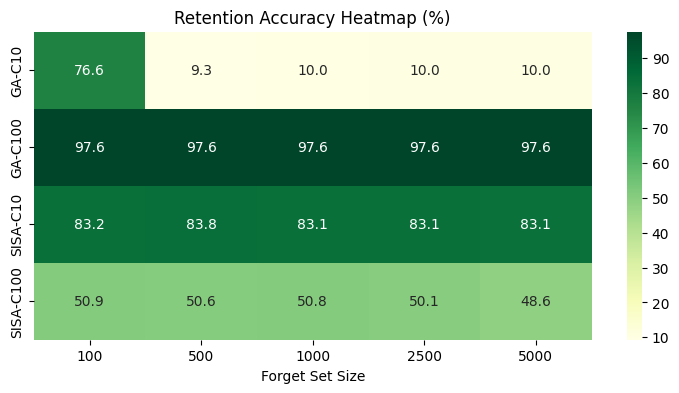

In [107]:
retain_matrix = np.array([
    ga10["retain_acc_after"].values,
    ga100["retain_acc_after"].values,
    sisa10["retain_acc_after"].values,
    sisa100["retain_acc_after"].values
])

plt.figure(figsize=(9,4))
sns.heatmap(
    retain_matrix,
    annot=True,
    fmt=".1f",
    cmap="YlGn",
    xticklabels=forget_sizes,
    yticklabels=labels
)
plt.xlabel("Forget Set Size")
plt.title("Retention Accuracy Heatmap (%)")
plt.show()


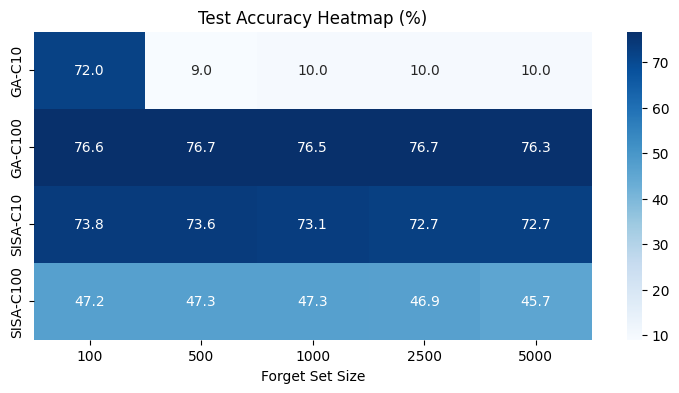

In [108]:
test_matrix = np.array([
    ga10["test_acc_after"].values,
    ga100["test_acc_after"].values,
    sisa10["test_acc_after"].values,
    sisa100["test_acc_after"].values
])

plt.figure(figsize=(9,4))
sns.heatmap(
    test_matrix,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    xticklabels=forget_sizes,
    yticklabels=labels
)
plt.xlabel("Forget Set Size")
plt.title("Test Accuracy Heatmap (%)")
plt.show()


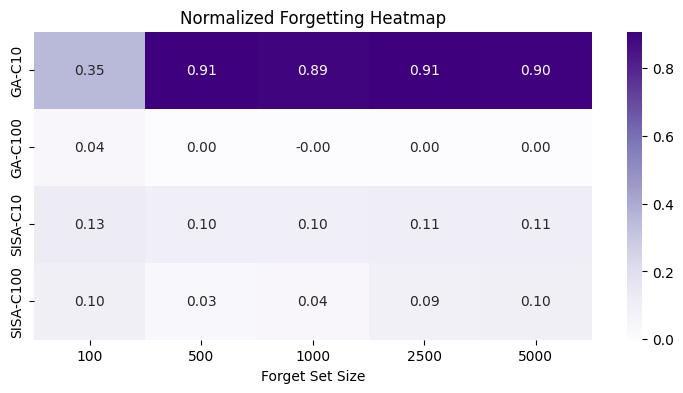

In [109]:
norm_forget_matrix = np.array([
    ga10["normalized_forget"].values,
    ga100["normalized_forget"].values,
    sisa10["normalized_forget"].values,
    sisa100["normalized_forget"].values
])

plt.figure(figsize=(9,4))
sns.heatmap(
    norm_forget_matrix,
    annot=True,
    fmt=".2f",
    cmap="Purples",
    xticklabels=forget_sizes,
    yticklabels=labels
)
plt.xlabel("Forget Set Size")
plt.title("Normalized Forgetting Heatmap")
plt.show()
